# classes and functions

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import sys
import os
import glob
import configparser

import h5py
import numpy as np

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

matplotlib.rcParams.update({'font.size': 18})

In [2]:
def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


def eta_from_q(q):
    """
    converts mass-ratio to symmetric mass-ratio
    input: q
    output: eta
    """
    return q/(1.+q)**2

In [3]:
class SingleModeNRWaveform(object):
    def __init__(self, nrfile, ell, mm, npts, t1=None, t2=None):

        self.nrfile = nrfile
        self.npts = npts
        self.t1=t1
        self.t2=t2

        self.get_lm_mode(self.nrfile, ell, mm, self.npts)


    def get_lm_mode(self, nrfile, ell, mm, npts):
        
        if 'SXS' in nrfile:
            f = h5py.File(nrfile, 'r')

            self.q = f.attrs['mass1']/f.attrs['mass2']
            self.eta = f.attrs['eta']

            amp_tmp = f['amp_l{0}_m{1}'.format(ell, mm)]
            amp_x = amp_tmp['X'].value
            amp_y = amp_tmp['Y'].value

            phase_tmp = f['phase_l{0}_m{1}'.format(ell, mm)]
            phase_x = phase_tmp['X'].value
            phase_y = phase_tmp['Y'].value

            f.close()
        else:
            # bam
            self.sim_dir = os.path.dirname(nrfile)
            self.bbh_file = glob.glob( os.path.join(self.sim_dir, '*.bbh') )[0]
            # strict=False because of DuplicateSectionError
            config = configparser.ConfigParser(strict=False)

            config.read(self.bbh_file)
            mass1_tmp = float(config['metadata']['mass1'])
            mass2_tmp = float(config['metadata']['mass2'])
            self.initial_sep = float(config['metadata']['initial-separation'])

            if mass1_tmp >= mass2_tmp:
                mass1 = mass1_tmp
                mass2 = mass2_tmp
            else:
                mass1 = mass2_tmp
                mass2 = mass1_tmp


            self.mass1 = mass1
            self.mass2 = mass2
            self.mtot = self.mass1 + self.mass2
            self.q = self.mass1 / self.mass2
            self.eta = self.mass1 * self.mass2 / (self.mtot)**2.
            
            times, re_hlm, im_hlm = np.loadtxt(nrfile, unpack=True)

            # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
            hlm = re_hlm - 1.j * im_hlm
            
            amp_x = times
            amp_y = np.abs(hlm)

            phase_x = times
            phase_y = np.unwrap(np.angle(hlm))
            
            
        # shift so that amp peak is at t=0 - will need to be more careful with HMs
        amp_peak_idx = amp_y.argmax()
        amp_peak_time = amp_x[amp_peak_idx]
        amp_x = amp_x - amp_peak_time
        phase_x = phase_x - amp_peak_time
            

        amp_i = IUS(amp_x, amp_y)
        phase_i = IUS(phase_x, phase_y)

        if self.t1 is None:
            self.t1 = max(amp_x[0], phase_x[0])
        if self.t2 is None:
            self.t2 = min(amp_x[-1], phase_x[-1])
            
        # t1,t2=-600,100

        common_times = np.linspace(self.t1, self.t2, npts)

        amplist = amp_i(common_times)
        phaselist = phase_i(common_times)

        self.times = common_times
        self.amp = amplist
        self.phi = phaselist
        # self.hlm["{0}, {1}".format(ell, mm)] = self.amp * np.exp(-1.j * self.phi)
        self.hlm = self.amp * np.exp(-1.j * self.phi)
        

    def resample_data(self, new_time_array):
        """
        new_time_array : numpy.array

        redefines the amp, phi and hlm attributes to be sampled on
        the new_time_array
        """
        amp_i = IUS(self.times, self.amp)
        phi_i = IUS(self.times, self.phi)

        self.npts = len(new_time_array)
        self.times = new_time_array
        self.amp = amp_i(new_time_array)
        self.phi = phi_i(new_time_array)
        self.hlm = self.amp * np.exp(-1.j * self.phi)


In [4]:
class Psi4(object):
    """
    stores Psi4 data aligned such that the peak of Psi4 is at t=0
    """
    def __init__(self, nrfile, ell, mm, npts_time, t1, t2):
        self.nrfile = nrfile
        self.ell = ell
        self.mm = mm
        self.npts_time = npts_time
        self.t1 = t1
        self.t2 = t2
        
        self.nrdata = SingleModeNRWaveform(self.nrfile, self.ell, self.mm, self.npts_time,t1=self.t1,t2=self.t2)
    
        self.eta = self.nrdata.eta
        self.q = float("{:.2f}".format(self.nrdata.q))
        
        ihlmre = IUS(self.nrdata.times, self.nrdata.hlm.real)
        ihlmim = IUS(self.nrdata.times, self.nrdata.hlm.imag)
        
        self.hlm_phase = np.unwrap(np.angle(self.nrdata.hlm))
        i_hlm_phase = IUS(self.nrdata.times, self.hlm_phase)
        self.hlm_ang_freq = i_hlm_phase.derivative()(self.nrdata.times)
        self.hlm_amp = np.abs(self.nrdata.hlm)
        
        psi4lmre = ihlmre.derivative().derivative()(self.nrdata.times)
        psi4lmim = ihlmim.derivative().derivative()(self.nrdata.times)

        self.psi4lm = psi4lmre - 1.j*psi4lmim
        
        self.psi4lm_amp = np.abs(self.psi4lm)
        
        # index of maximum
        max_idx = self.psi4lm_amp.argmax()
        # time of maximum
        self.time_at_max_idx = self.nrdata.times[max_idx]
        
        self.times = self.nrdata.times - self.time_at_max_idx
        
        
        
        self.psi4lm_phase = np.unwrap(np.angle(self.psi4lm))
        i_psi4lm_phase = IUS(self.times, self.psi4lm_phase)
        self.psi4lm_ang_freq = i_psi4lm_phase.derivative()(self.times)
        
        

        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
#         self.ang_f_22_isco = phenom.HztoMf(f_SchwarzISCO(self.final_mass), self.final_mass)

        m1 = mass1_from_mtotal_eta(1., eta)
        m2 = mass2_from_mtotal_eta(1., eta)
#         self.hyb_meco_ang_freq = phenom.HztoMf(hybrid_meco_frequency(m1, m2, chi1z, chi2z), self.final_mass) * 2 * np.pi

        # get from TaylorT3 orb frequency: https://arxiv.org/abs/0901.2437
#         leading_order = 2
        
    
    
        # time shift between peak of strain and peak of psi4
        # index of maximum
        hlm_max_idx = self.hlm_amp.argmax()
        # time of maximum
        self.hlm_time_at_max_idx = self.nrdata.times[hlm_max_idx]

In [5]:
# get data
nrfiles = dict(
    q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
    q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
    q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
    q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
    q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
    q18="/Users/spx8sk/work/data/q18a0a0c025_144/h3col.r7.l5.l2.m2"
)

In [6]:
ell = 2
mm = 2

npts_time = 1000*2
npts_mass_ratio = len(nrfiles)

# t1=None
# t2=None
t1=-600
# t1=-1000
# t1=-800
t2=60


In [7]:
psi4s = {}
for k,v in list(nrfiles.items()):
    psi4s.update({k:Psi4(v, ell, mm, npts_time,t1=t1,t2=t2)})

/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [8]:
for k in psi4s.keys():
    print("{} = {}".format(k, 1./psi4s[k].fdamp/2/np.pi))

q1 = 11.706422641558191
q2 = 11.554740530290251
q4 = 11.36516841490208
q5 = 11.32930696199893
q10 = 11.272552160962043
q18 = 11.255711435422901


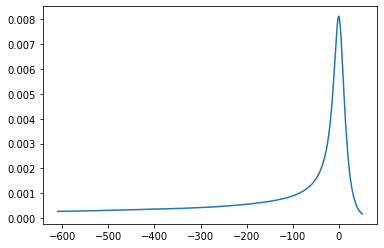

In [9]:
plt.figure()
plt.plot(psi4s['q18'].times, psi4s['q18'].psi4lm_amp)

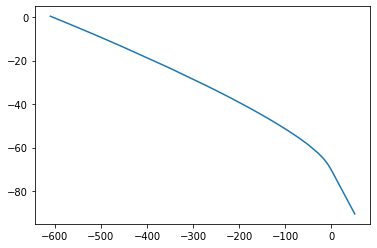

In [10]:
plt.figure()
plt.plot(psi4s['q18'].times, psi4s['q18'].psi4lm_phase)

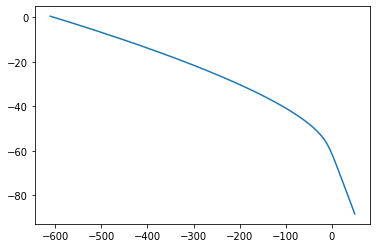

In [11]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_phase)

Text(0.5, 1.0, '$|h|(t)$')

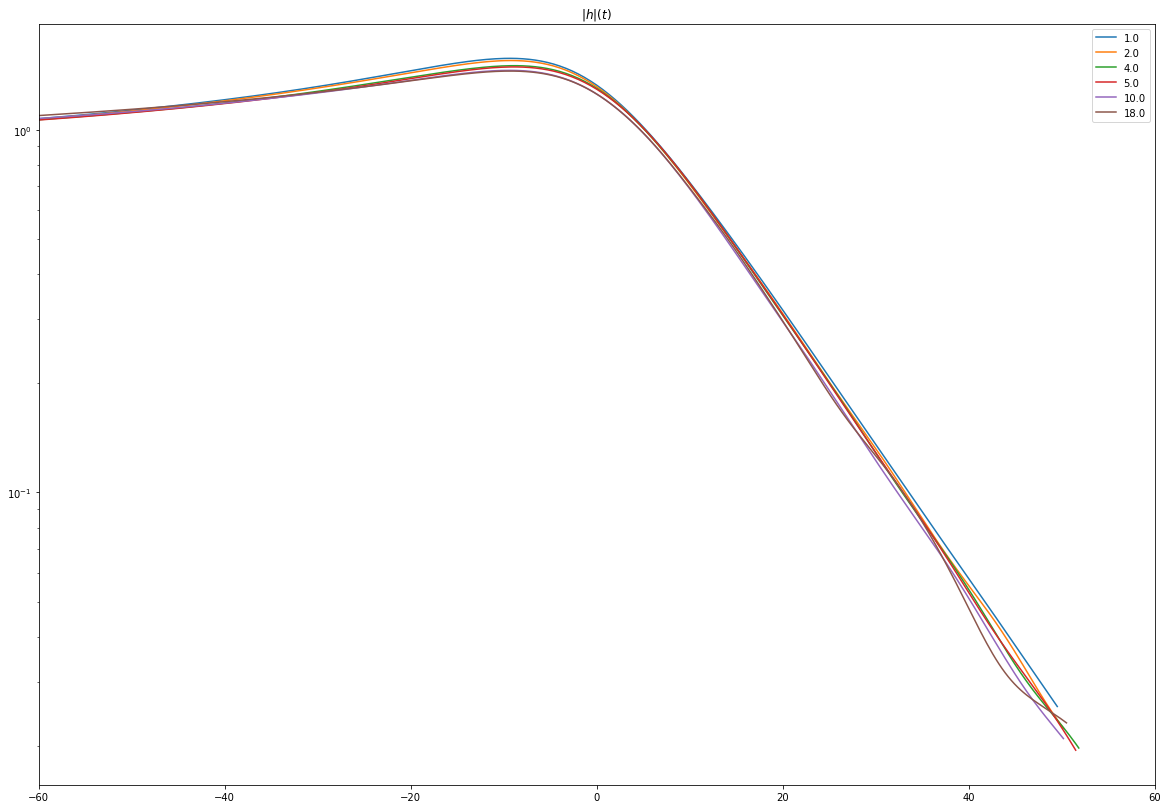

In [12]:
plt.figure(figsize=(20, 14))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].hlm_amp / psi4s[k].eta, label=psi4s[k].q)
#     plt.plot(psi4s[k].times, psi4s[k].hlm_amp, label=psi4s[k].q)
plt.legend()
plt.xlim(-60,60)
# plt.ylim(0.2, 1.6)
plt.yscale('log')
plt.title(r'$|h|(t)$')

Text(0.5, 1.0, '$|\\Psi_4|(t)$')

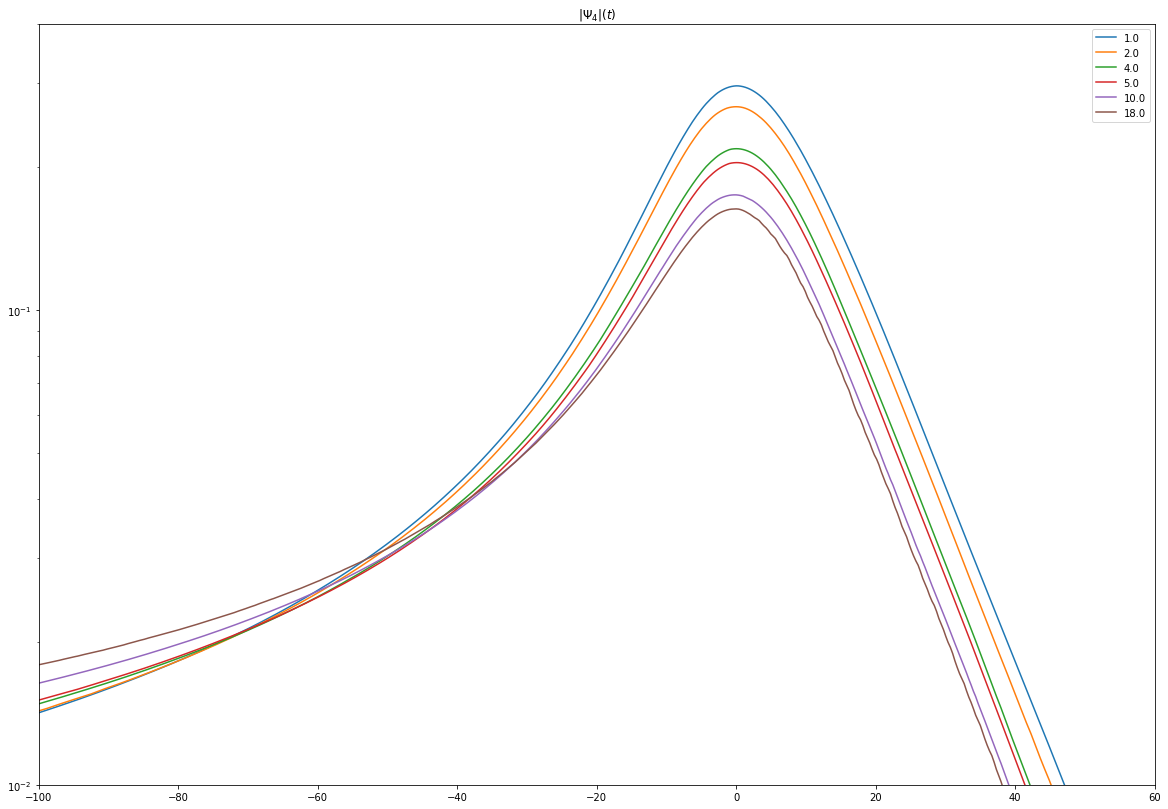

In [13]:
plt.figure(figsize=(20, 14))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_amp / psi4s[k].eta, label=psi4s[k].q)
    
plt.legend()
plt.xlim(-100,60)
plt.ylim(1e-2, 0.4)
plt.yscale('log')
plt.title(r'$|\Psi_4|(t)$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $\\Psi_4$')

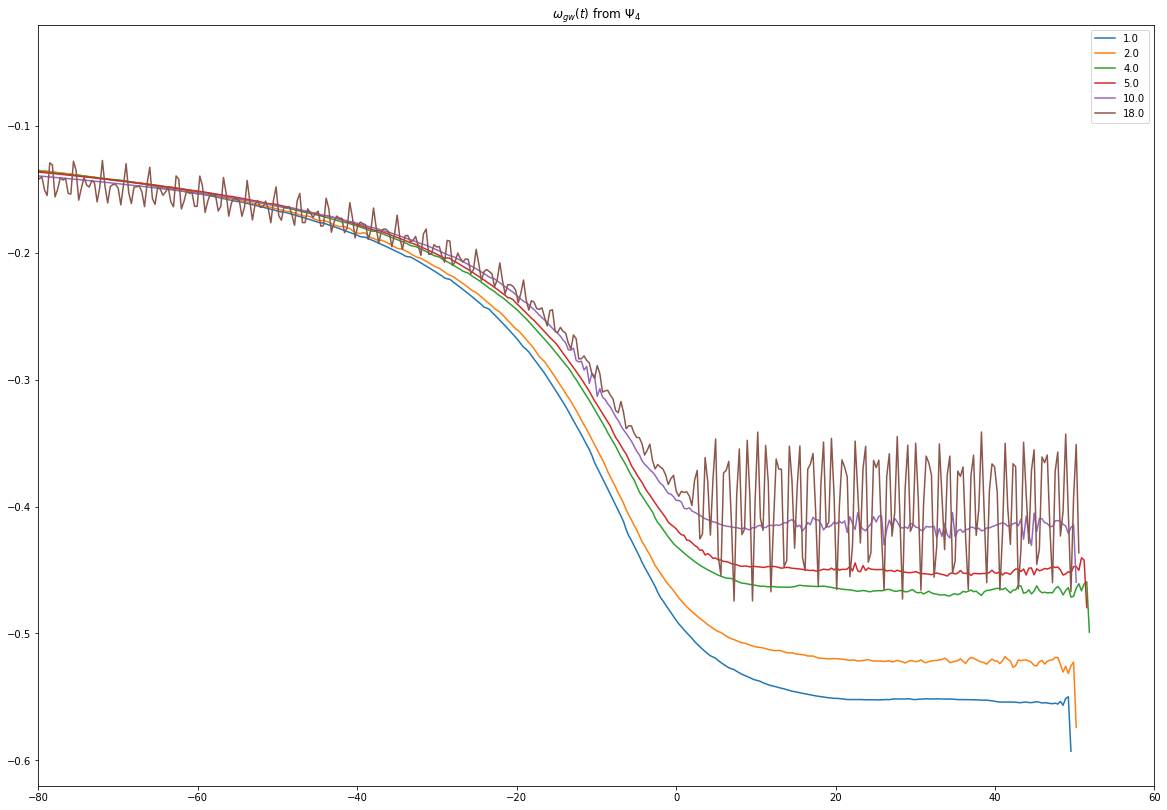

In [14]:
plt.figure(figsize=(20, 14))
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $\Psi_4$')

Text(0.5, 1.0, '$\\omega_{gw}(t)$ from $h$')

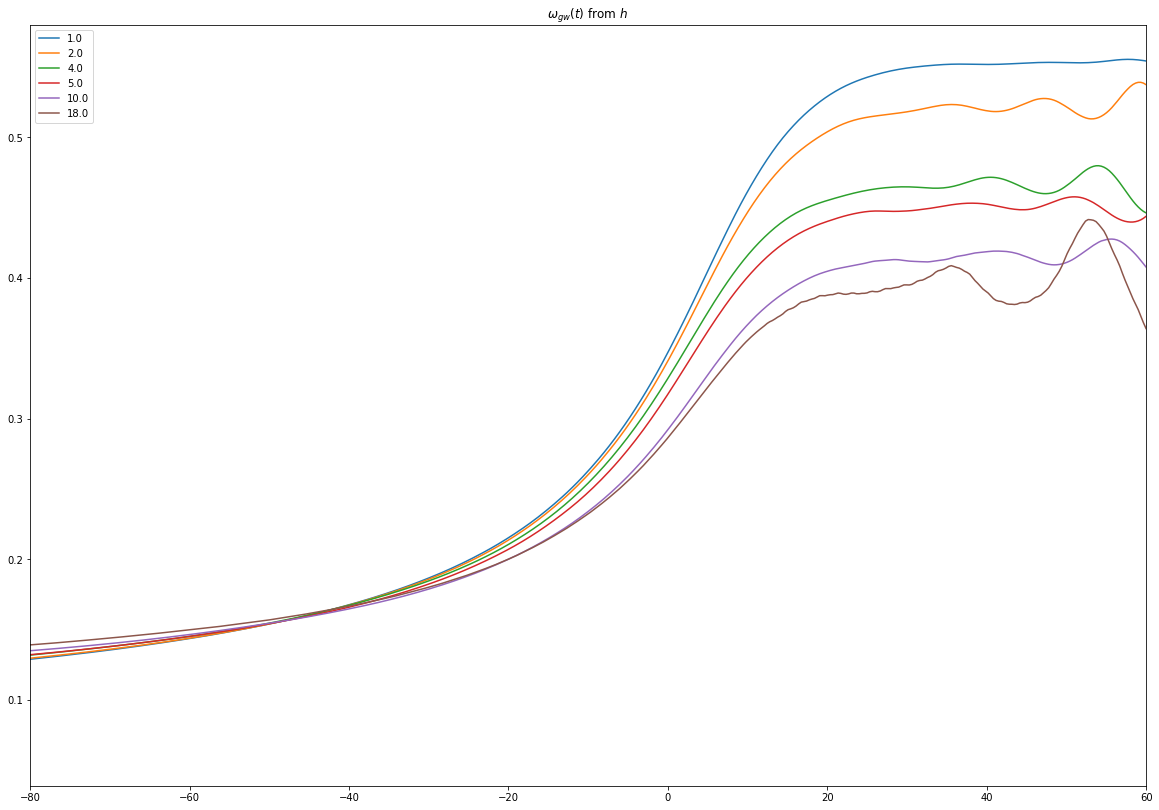

In [15]:
plt.figure(figsize=(20, 14))
for k in psi4s.keys():
    plt.plot(psi4s[k].nrdata.times, psi4s[k].hlm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$ from $h$')

Text(0.5, 1.0, 'q = 1.0')

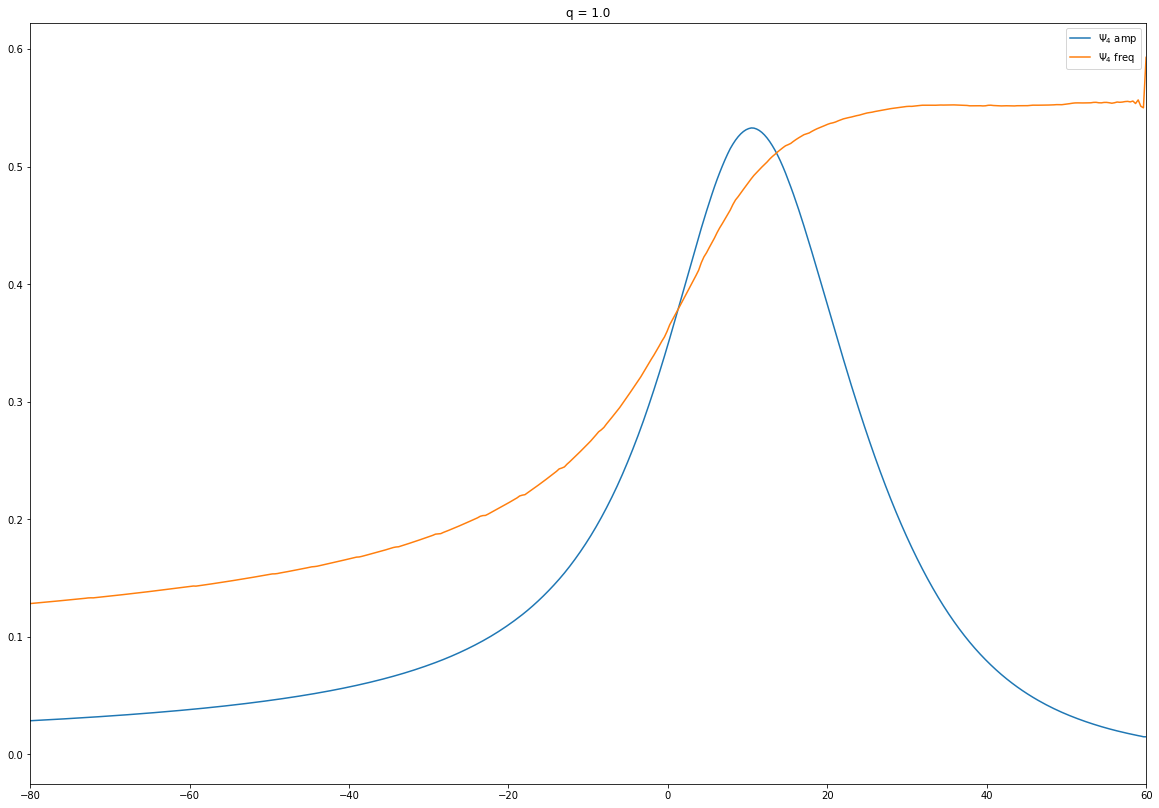

In [16]:
# compare psi4_amp and freq
k = 'q1'

plt.figure(figsize=(20, 14))
plt.plot(psi4s[k].nrdata.times, psi4s[k].psi4lm_amp / psi4s[k].eta * 1.8, label='$\Psi_4$ amp')
plt.plot(psi4s[k].nrdata.times, -psi4s[k].psi4lm_ang_freq, label='$\Psi_4$ freq')
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'q = {}'.format(psi4s[k].q))

## function to fit using lmfit

In [17]:
class Model(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_amp_ramp_up(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        lor_amp = params['lor_amp']
        a0 = params['a0']
        a1 = params['a1']
        
#         a2 = params['a2']
        
        model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp) + a1 / (t - tp)**2
#         model +=+ a2 / (t - tp)**4
        
#         a_tdamp = params['a_tdamp']
#         a_tp = params['a_tp']
#         a_ap = params['a_ap']
        
#         sech = 1/np.cosh( (a_tp - t) / a_tdamp )
#         model += a_ap * sech
        
        
        return model
    
    def model_amp_ramp_up_to_min(self, params, t, data):
        model = self.model_amp_ramp_up(params, t)
        return model - data
        
    def fit_amp_ramp_up(self, fix_tdamp, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
        self.model_amp_ramp_up_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times = self.Psi4.times[self.model_amp_ramp_up_mask]
        self.fit_data = self.Psi4.psi4lm_amp[self.model_amp_ramp_up_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        if fix_tdamp:
            params.add('tdamp', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        else:
            params.add('tdamp', value=20., min=1, max=200)
        
        params.add('tp', value=20, min=-100, max=200)
        params.add('lor_amp', value=0., min=-2000, max=2000)
        params.add('a0', value=0., min=-2000, max=2000)
        params.add('a1', value=0., min=-2000, max=4000)
        
#         params.add('a2', value=100., min=-800000, max=400000)
        
        
#         params.add('a_tdamp', value=20., min=1, max=200)
#         params.add('a_tp', value=0, min=-100, max=200)
#         params.add('a_ap', value=0., min=-2000, max=2000)
        
        fcn2min = self.model_amp_ramp_up_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.amp_ramp_up_result = minner.minimize()

        # calculate final result
        self.amp_ramp_up_final = self.fit_data + self.amp_ramp_up_result.residual

        # write error report
        report_fit(self.amp_ramp_up_result)
        
        
        
    def model_amp_bob(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        ap = params['ap']
        
#         tdamp_vary = params['tdamp_vary']
#         t1 = tdamp/4
#         t2 = t1 + 10
#         t1 = 15
#         t2 = t1 + 20
#         trans = self.planck_taper(t, t1, t2)
        
#         vary_damp =  (1. - trans) * tdamp_vary + trans * tdamp
#         vary_damp = tdamp
        
#         sech = 1/np.cosh( (tp - t) / tdamp )
#         sech = 1/np.cosh( (tp - t) / vary_damp + (params['b']*(tp - t) / vary_damp)**2 )

        sech = 1/np.cosh( (tp - t) / tdamp )
        model = ap * sech

        return model
    
    def model_amp_bob_to_min(self, params, t, data):
        model = self.model_amp_bob(params, t)
        return model - data
        
    def fit_amp_bob(self, fix_tdamp, t1=-20, t2=20):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
        self.model_amp_bob_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times_bob = self.Psi4.times[self.model_amp_bob_mask]
        self.fit_data_bob = self.Psi4.psi4lm_amp[self.model_amp_bob_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        if fix_tdamp:
            params.add('tdamp', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        else:
            params.add('tdamp', value=20., min=1, max=200)
        
        params.add('tp', value=0, min=-100, max=200)
        params.add('ap', value=0., min=-2000, max=2000)
        
#         params.add('tdamp_vary', value=20., min=1, max=200)
#         params.add('b', value=0., min=-2000, max=2000)
        
        
        fcn2min = self.model_amp_bob_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times_bob, self.fit_data_bob))
        
        self.amp_bob_result = minner.minimize()

        # calculate final result
        self.amp_bob_final = self.fit_data_bob + self.amp_bob_result.residual

        # write error report
        report_fit(self.amp_bob_result)
        
    def planck_taper(self, times, t1, t2):
        """times: array of times
        t1. for t<=t1 then return 0
        t2. for t>=t2 then return 1
        else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
        tout = []
        for t in times:
            if t<=t1:
                tout.append(0.)
            elif t>=t2:
                tout.append(1.)
            else:
                tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
        return np.array(tout)
        
    def amp_model(self, times, t0 = -10, sigma=10, params_ramp_up=None, params_bob=None):
        
        if params_ramp_up is None:
            params_ramp_up = self.amp_ramp_up_result.params
        if params_bob is None:
            params_bob = self.amp_bob_result.params
        
        self.ramp_up = self.model_amp_ramp_up(params_ramp_up, times)
        self.bob = self.model_amp_bob(params_bob, times)
        
        t1 = t0 - sigma/2.
        t2 = t0 + sigma/2.
        self.trans = self.planck_taper(times, t1, t2)
        
        return (1. - self.trans) * self.ramp_up + self.trans * self.bob
        
    def compare_model_with_data(self, t0=-10, sigma=10):
        self.t_data, self.y_data = self.Psi4.times, self.Psi4.psi4lm_amp
        self.y_model = self.amp_model(self.t_data, t0=t0, sigma=sigma)

In [18]:
q1_fit = Model(psi4s['q1'])
q1_fit.fit_amp_ramp_up(fix_tdamp=False, t1=-800, t2=-10)
q1_fit.fit_amp_bob(fix_tdamp=False, t1=-10, t2=20)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 1819
    # variables        = 5
    chi-square         = 3.2958e-06
    reduced chi-square = 1.8168e-09
    Akaike info crit   = -36604.5022
    Bayesian info crit = -36576.9720
[[Variables]]
    tdamp:    29.2450726 +/- 4.89287356 (16.73%) (init = 20)
    tp:       23.9298313 +/- 2.73903776 (11.45%) (init = 20)
    lor_amp: -3.44859825 +/- 2.17644415 (63.11%) (init = 0)
    a0:      -0.36914549 +/- 0.00130725 (0.35%) (init = 0)
    a1:       103.797439 +/- 47.4636049 (45.73%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1)    = -1.000
    C(tp, a1)         =  1.000
    C(tp, lor_amp)    = -1.000
    C(tdamp, lor_amp) =  1.000
    C(tdamp, a1)      = -1.000
    C(tdamp, tp)      = -1.000
    C(tp, a0)         = -0.838
    C(a0, a1)         = -0.835
    C(lor_amp, a0)    =  0.833
    C(tdamp, a0)      =  0.826
[[Fit Statistics]]
    # fitting meth

In [19]:
q1_fit_fix_tdamp = Model(psi4s['q1'])
q1_fit_fix_tdamp.fit_amp_ramp_up(fix_tdamp=True, t1=-800, t2=-10)
# q1_fit_fix_tdamp.fit_amp_bob(fix_tdamp=True, t1=-10, t2=20)
q1_fit_fix_tdamp.fit_amp_bob(fix_tdamp=True, t1=-10, t2=60)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 1819
    # variables        = 4
    chi-square         = 3.8727e-06
    reduced chi-square = 2.1337e-09
    Akaike info crit   = -36313.0793
    Bayesian info crit = -36291.0551
[[Variables]]
    tdamp:    11.70642 (fixed)
    tp:       31.7240596 +/- 0.08171694 (0.26%) (init = 20)
    lor_amp: -80.4346653 +/- 0.75178897 (0.93%) (init = 0)
    a0:      -0.37420868 +/- 8.5165e-04 (0.23%) (init = 0)
    a1:       945.802066 +/- 8.67369962 (0.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.994
    C(tp, lor_amp) = -0.994
    C(lor_amp, a0) =  0.774
    C(a0, a1)      = -0.769
    C(tp, a0)      = -0.720
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 181
    # variables        = 2
    chi-square         = 1.1585e-04
    reduced chi-square = 6.4723e-07
    

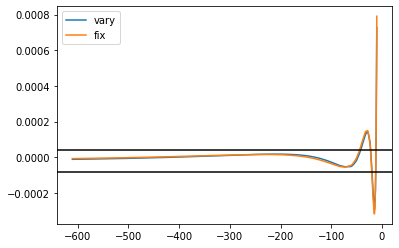

In [20]:

plt.figure()
# plt.plot(q1_fit.fit_times, q1_fit.fit_data)
plt.plot(q1_fit.fit_times, q1_fit.amp_ramp_up_result.residual, label='vary')
plt.plot(q1_fit_fix_tdamp.fit_times, q1_fit_fix_tdamp.amp_ramp_up_result.residual, label='fix')
plt.legend()
plt.axhline(4e-5, c='k')
plt.axhline(-8e-5, c='k')

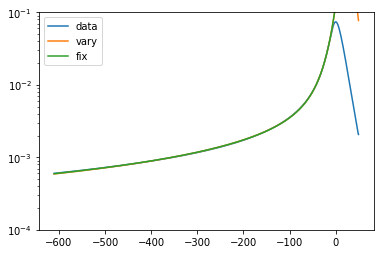

In [21]:
plt.figure()
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data')

plt.plot(q1_fit.Psi4.times, q1_fit.model_amp_ramp_up(q1_fit.amp_ramp_up_result.params,q1_fit.Psi4.times), label='vary')
plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times), label='fix')

plt.legend()
# plt.xlim(-600,100)
plt.ylim(0.0001,0.1)
plt.yscale('log')


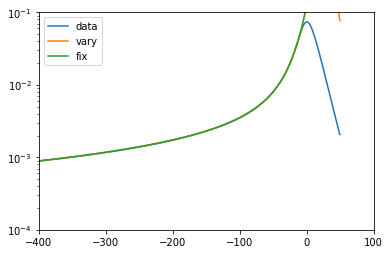

In [22]:
plt.figure()
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data')

plt.plot(q1_fit.Psi4.times, q1_fit.model_amp_ramp_up(q1_fit.amp_ramp_up_result.params,q1_fit.Psi4.times), label='vary')
plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times), label='fix')

plt.legend()
# plt.xlim(-600,100)
plt.xlim(-400,100)
plt.ylim(0.0001,0.1)
plt.yscale('log')


(-10, 10)

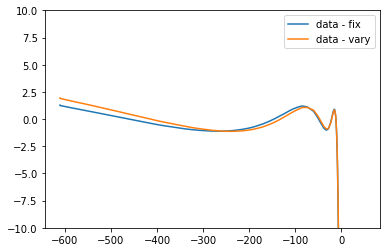

In [23]:
# residuals in extrapolation

ttt = q1_fit.Psi4.times
dddata = q1_fit.Psi4.psi4lm_amp
dddvary = q1_fit.model_amp_ramp_up(q1_fit.amp_ramp_up_result.params,q1_fit.Psi4.times)
dddfix = q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times)

plt.figure()
plt.plot(ttt, 100*(dddata - dddfix)/dddata, label='data - fix')
plt.plot(ttt, 100*(dddata - dddvary)/dddata, label='data - vary')
plt.legend()
# plt.xlim(-600,100)
plt.ylim(-10,10)



## bob

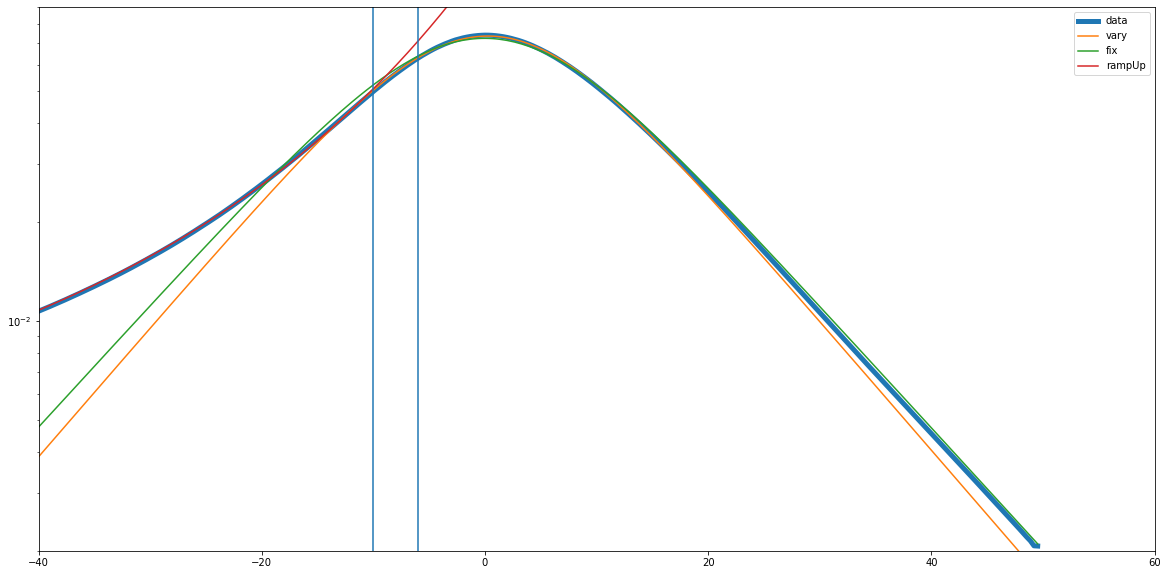

In [24]:
plt.figure(figsize=(20,10))
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data', lw=5)

plt.plot(q1_fit.Psi4.times, q1_fit.model_amp_bob(q1_fit.amp_bob_result.params,q1_fit.Psi4.times), label='vary')
plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_bob(q1_fit_fix_tdamp.amp_bob_result.params,q1_fit_fix_tdamp.Psi4.times), label='fix')

plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times), label='rampUp')

plt.legend()
# plt.xlim(-40, 20)
# plt.ylim(0.004,0.09)

plt.xlim(-40, 60)
plt.ylim(0.002,0.09)
plt.axvline(-6)
plt.axvline(-10)

plt.yscale('log')


In [25]:
test_full_amp = q1_fit_fix_tdamp.amp_model(psi4s['q1'].times, t0=-10, sigma=10)

(-30, 30)

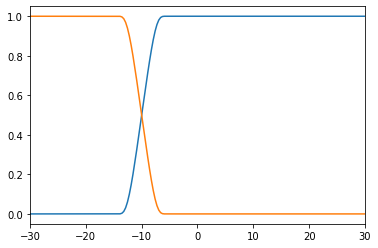

In [26]:
plt.figure()
plt.plot(psi4s['q1'].times, q1_fit_fix_tdamp.trans)
plt.plot(psi4s['q1'].times, 1. - q1_fit_fix_tdamp.trans)
plt.xlim(-30,30)

(-60, 70)

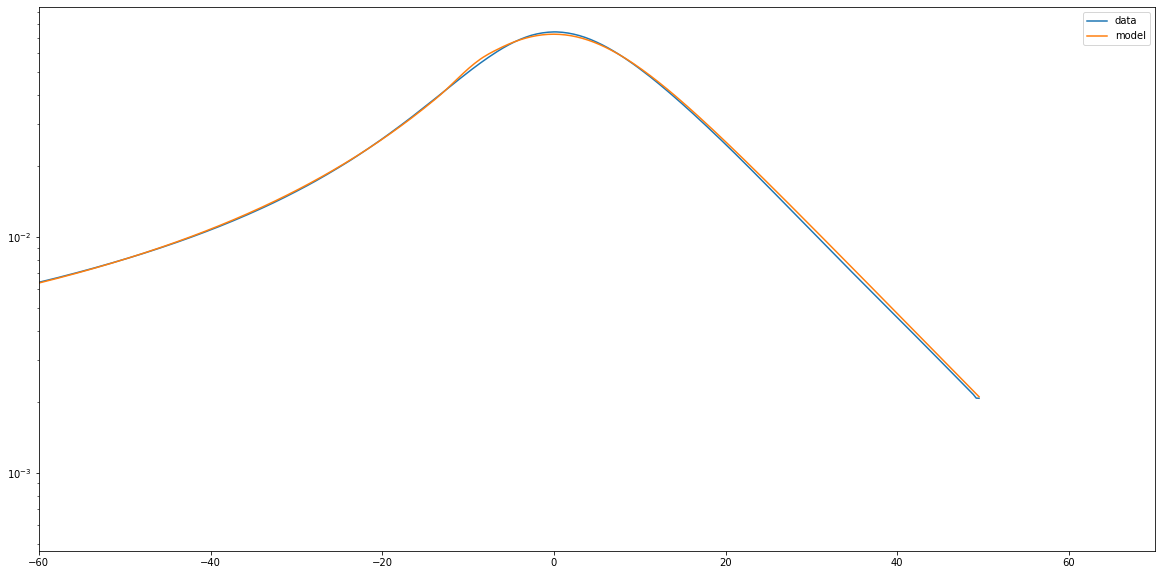

In [27]:
plt.figure(figsize=(20,10))
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data')

# plt.plot(psi4s['q1'].times, q1_fit_fix_tdamp.ramp_up, label='rampup')
# plt.plot(psi4s['q1'].times, q1_fit_fix_tdamp.bob, label='bob')

plt.plot(psi4s['q1'].times, test_full_amp, label='model')

plt.yscale('log')
plt.legend()
plt.xlim(-60,70)
# plt.ylim(0.02,0.08)

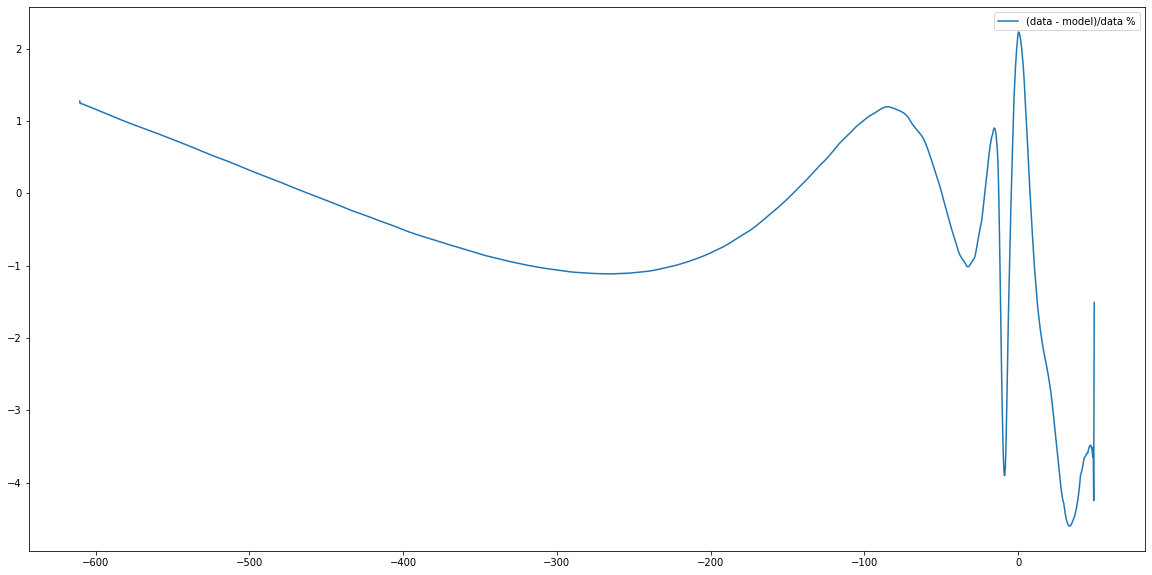

In [28]:
plt.figure(figsize=(20,10))
plt.plot(q1_fit.Psi4.times, 100*(q1_fit.Psi4.psi4lm_amp - test_full_amp)/q1_fit.Psi4.psi4lm_amp, label='(data - model)/data %')

plt.legend()
# plt.xlim(-40,40)
# plt.ylim(0.02,0.08)

In [29]:
q1_fit_fix_tdamp.compare_model_with_data()

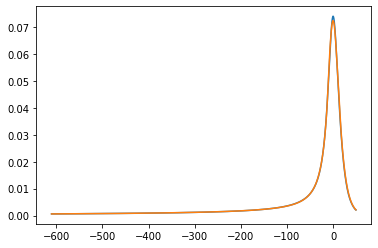

In [30]:
plt.figure()
plt.plot(q1_fit_fix_tdamp.t_data, q1_fit_fix_tdamp.y_data)
plt.plot(q1_fit_fix_tdamp.t_data, q1_fit_fix_tdamp.y_model)

# loop over all cases

In [31]:
fit_psi4s = {}
for k in psi4s.keys():
    print('working: {}'.format(k))
    print("\n")
    fit_psi4s.update({k:Model(psi4s[k])})
    print("fitting ramp up")
    fit_psi4s[k].fit_amp_ramp_up(fix_tdamp=True, t1=-800, t2=-10)
    print("\n")
    print("fitting bob")
    fit_psi4s[k].fit_amp_bob(fix_tdamp=True, t1=-10, t2=20)
    print("\n")
    
    fit_psi4s[k].compare_model_with_data()

working: q1


fitting ramp up
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 1819
    # variables        = 4
    chi-square         = 3.8727e-06
    reduced chi-square = 2.1337e-09
    Akaike info crit   = -36313.0793
    Bayesian info crit = -36291.0551
[[Variables]]
    tdamp:    11.70642 (fixed)
    tp:       31.7240596 +/- 0.08171694 (0.26%) (init = 20)
    lor_amp: -80.4346653 +/- 0.75178897 (0.93%) (init = 0)
    a0:      -0.37420868 +/- 8.5165e-04 (0.23%) (init = 0)
    a1:       945.802066 +/- 8.67369962 (0.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.994
    C(tp, lor_amp) = -0.994
    C(lor_amp, a0) =  0.774
    C(a0, a1)      = -0.769
    C(tp, a0)      = -0.720


fitting bob
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 91
    # variables        = 2
    chi-square         = 1.0060e-

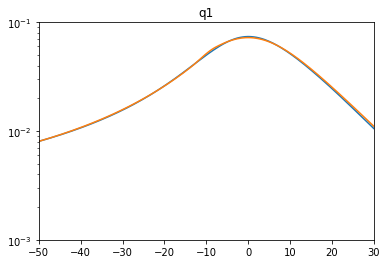

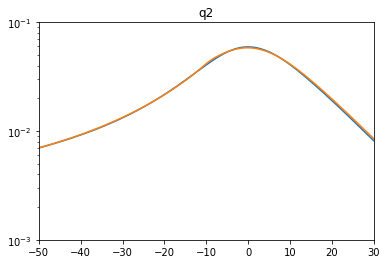

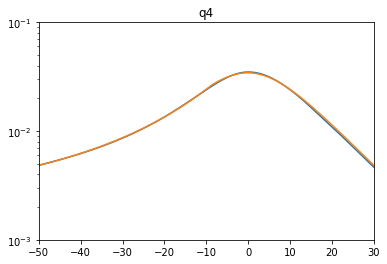

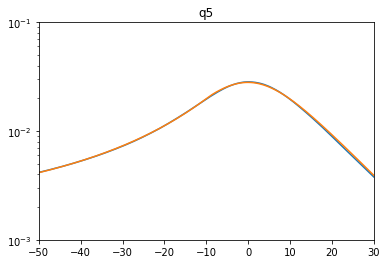

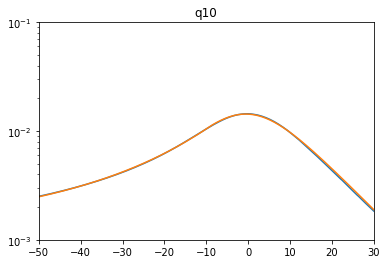

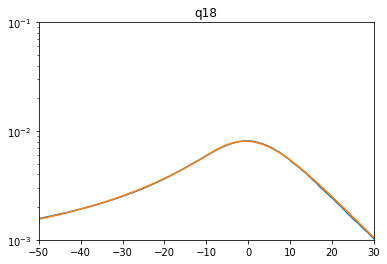

In [32]:
for k in fit_psi4s.keys():
    plt.figure()
    plt.plot(fit_psi4s[k].t_data, fit_psi4s[k].y_data)
    plt.plot(fit_psi4s[k].t_data, fit_psi4s[k].y_model)
    plt.title(k)
    plt.xlim(-50,30)
    plt.ylim(0.001,0.1)
    plt.yscale('log')
    plt.show()
    plt.close()

## frequency fitting using lmfit

In [33]:
class Model_frequency(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_freq_ramp_up(self, params, t):
        
        t0 = params['t0']
        a = params['a']
        b = params['b']
        c = params['c']
        d = params['d']
#         e = params['e']
#         model = (a*b) / ( (t-t0)**2 + a**2 ) + c/(t-t0) + d/(t-t0)**2
        model = (a*b) / ( (t-t0)**2 + a**2 ) + c/(t-t0) + d/(t-t0)**3
#         model = (a*b) / ( (t-t0)**2 + a**2 ) + c/(t-t0) + d/(t-t0)**4
        
        return model
    
    def model_freq_ramp_up_to_min(self, params, t, data):
        model = self.model_freq_ramp_up(params, t)
        return model - data
        
    def fit_freq_ramp_up(self, t1=-200, t2=0):
        self.model_freq_ramp_up_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times = self.Psi4.times[self.model_freq_ramp_up_mask]
        self.fit_data = self.Psi4.psi4lm_ang_freq[self.model_freq_ramp_up_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('t0', value=0, min=-30, max=300)
        params.add('a', value=10., min=-2000, max=5000)
        params.add('b', value=0., min=-2000, max=20000)
        params.add('c', value=0., min=-2000, max=2000)
        params.add('d', value=0., min=-1000000, max=4000)
#         params.add('e', value=0., min=-1000000, max=10000)
        
        fcn2min = self.model_freq_ramp_up_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_ramp_up_result = minner.minimize()

        # calculate final result
        self.freq_ramp_up_final = self.fit_data + self.freq_ramp_up_result.residual

        # write error report
        report_fit(self.freq_ramp_up_result)
        
        
        
    def model_freq_mr(self, params, t):
        t0 = params['t0']
        kappa = params['kappa']
        b = params['b']
        om_f = params['om_f']
        offset = params['offset']

        dt = t - t0
#         num = 1. + np.tanh(np.log(np.sqrt(kappa)) - (dt/b))
        num = 1. + np.tanh((dt/b))
        den = 2.

        model = offset + (om_f - offset) * (num/den)**kappa
        
        return model
    
    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-20, t2=20):
        self.model_freq_mr_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times_mr = self.Psi4.times[self.model_freq_mr_mask]
        self.fit_data_mr = self.Psi4.psi4lm_ang_freq[self.model_freq_mr_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('t0', value=5., min=-200, max=200)
#         params.add('t0', value=tp_amp, vary=False)
#         params.add('kappa', value=1, min=1e-9, max=10)
        params.add('kappa', value=1, vary=False)
#         params.add('kappa', value=1, vary=True, min=0.1, max=100)
        # params.add('kappa', value=0.25, vary=False) # bob value?
#         params.add('kappa', value=0.36, vary=False) # best fit value?
        # params.add('b', value=1., min=1e-8, max=30)
#         params.add('b', value=10., vary=False)
        # fixing b is ok but fitting is better
        params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
#         params.add('b', value=-1./self.Psi4.fdamp/2/np.pi, vary=False)
#         params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=True)
        # params.add('om_f', value=fring * np.pi * 2, min=0.02, max=1)
        params.add('om_f', value=-self.Psi4.fring*2*np.pi, vary=False)
        params.add('offset', value=0., min=-200, max=200)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times_mr, self.fit_data_mr))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data_mr + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)
        
    def planck_taper(self, times, t1, t2):
        """times: array of times
        t1. for t<=t1 then return 0
        t2. for t>=t2 then return 1
        else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
        tout = []
        for t in times:
            if t<=t1:
                tout.append(0.)
            elif t>=t2:
                tout.append(1.)
            else:
                tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
        return np.array(tout)
        
    def freq_model(self, times, t0 = -20, sigma=10, params_ramp_up=None, params_mr=None):
        
        if params_ramp_up is None:
            params_ramp_up = self.freq_ramp_up_result.params
        if params_mr is None:
            params_mr = self.freq_mr_result.params
        
        self.ramp_up = self.model_freq_ramp_up(params_ramp_up, times)
        self.mr = self.model_freq_mr(params_mr, times)
        
        t1 = t0 - sigma/2.
        t2 = t0 + sigma/2.
        self.trans = self.planck_taper(times, t1, t2)
        
        return (1. - self.trans) * self.ramp_up + self.trans * self.mr
        
    def compare_model_with_data(self, t0=-10, sigma=10):
        self.t_data, self.y_data = self.Psi4.times, self.Psi4.psi4lm_ang_freq
        self.y_model = self.freq_model(self.t_data, t0=t0, sigma=sigma)

In [34]:
q1_freq_model = Model_frequency(psi4s['q1'])
print("fitting ramp up")
q1_freq_model.fit_freq_ramp_up(t1=-600, t2=-0.5)
print("\n")
print("fitting mr")
q1_freq_model.fit_freq_mr(t1=-20, t2=40)

fitting ramp up
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 102
    # data points      = 1816
    # variables        = 5
    chi-square         = 0.00283107
    reduced chi-square = 1.5633e-06
    Akaike info crit   = -24272.6289
    Bayesian info crit = -24245.1069
[[Variables]]
    t0:  8.17773813 +/- 0.03760131 (0.46%) (init = 0)
    a:   1133.29606 +/- 5.75870540 (0.51%) (init = 10)
    b:  -76.8252055 +/- 0.29081984 (0.38%) (init = 0)
    c:   5.89098177 +/- 0.01241271 (0.21%) (init = 0)
    d:  -180.276152 +/- 1.07102525 (0.59%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)  = -0.977
    C(c, d)  = -0.929
    C(t0, c) =  0.908
    C(t0, d) = -0.784
    C(a, c)  =  0.663
    C(a, d)  = -0.608
    C(b, c)  = -0.523
    C(t0, a) =  0.510
    C(b, d)  =  0.477
    C(t0, b) = -0.386


fitting mr
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 182
    # variables   

(-600, 10)

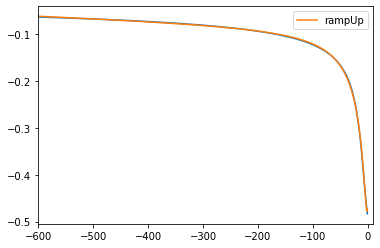

In [35]:

plt.figure()
plt.plot(q1_freq_model.fit_times, q1_freq_model.fit_data)

plt.plot(q1_freq_model.fit_times, q1_freq_model.model_freq_ramp_up(
                                            q1_freq_model.freq_ramp_up_result.params,
                                            q1_freq_model.fit_times
                                            ),
         label='rampUp')

plt.legend()
plt.xlim(-600,10)

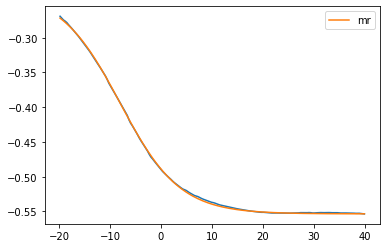

In [36]:

plt.figure()
plt.plot(q1_freq_model.fit_times_mr, q1_freq_model.fit_data_mr)

plt.plot(q1_freq_model.fit_times_mr, q1_freq_model.model_freq_mr(
                                            q1_freq_model.freq_mr_result.params,
                                            q1_freq_model.fit_times_mr
                                            ),
         label='mr')

plt.legend()
# plt.xlim(-600,10)

In [37]:
fit_psi4s_freq = {}
for k in psi4s.keys():
    print('working: {}'.format(k))
    print("\n")
    fit_psi4s_freq.update({k:Model_frequency(psi4s[k])})
    print("fitting ramp up")
    fit_psi4s_freq[k].fit_freq_ramp_up(t1=-600, t2=-0.5)
    print("\n")
    print("fitting bob")
    fit_psi4s_freq[k].fit_freq_mr(t1=-20, t2=40)
#     fit_psi4s_freq[k].fit_freq_mr(t1=-40, t2=40)
    print("\n")
    
    fit_psi4s_freq[k].compare_model_with_data()

working: q1


fitting ramp up
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 102
    # data points      = 1816
    # variables        = 5
    chi-square         = 0.00283107
    reduced chi-square = 1.5633e-06
    Akaike info crit   = -24272.6289
    Bayesian info crit = -24245.1069
[[Variables]]
    t0:  8.17773813 +/- 0.03760131 (0.46%) (init = 0)
    a:   1133.29606 +/- 5.75870540 (0.51%) (init = 10)
    b:  -76.8252055 +/- 0.29081984 (0.38%) (init = 0)
    c:   5.89098177 +/- 0.01241271 (0.21%) (init = 0)
    d:  -180.276152 +/- 1.07102525 (0.59%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)  = -0.977
    C(c, d)  = -0.929
    C(t0, c) =  0.908
    C(t0, d) = -0.784
    C(a, c)  =  0.663
    C(a, d)  = -0.608
    C(b, c)  = -0.523
    C(t0, a) =  0.510
    C(b, d)  =  0.477
    C(t0, b) = -0.386


fitting bob
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 182
   

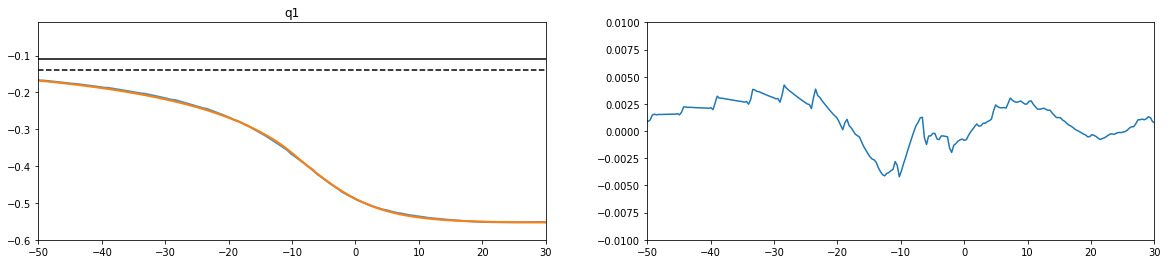

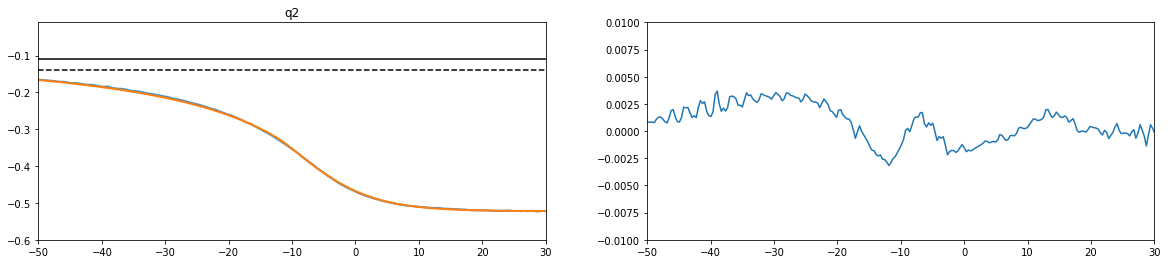

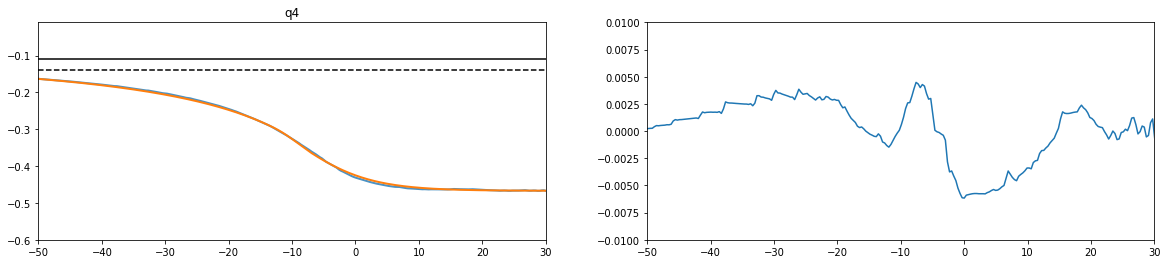

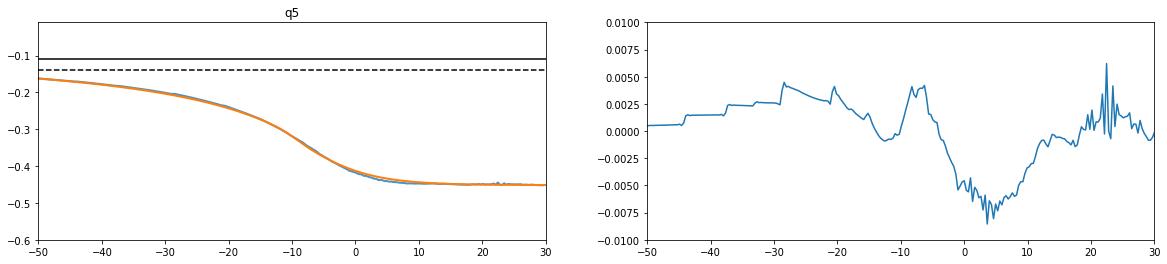

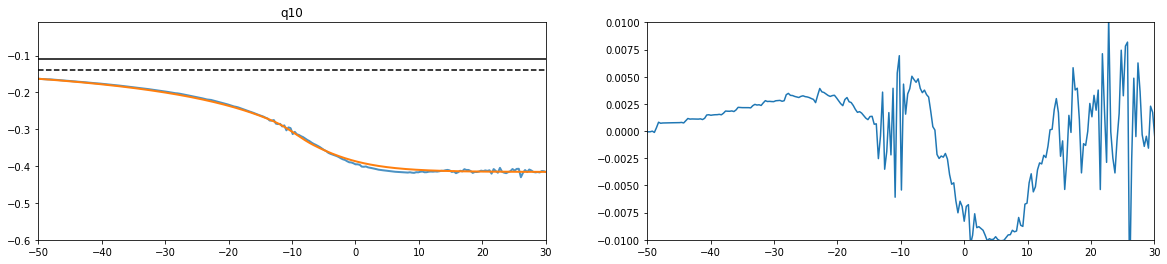

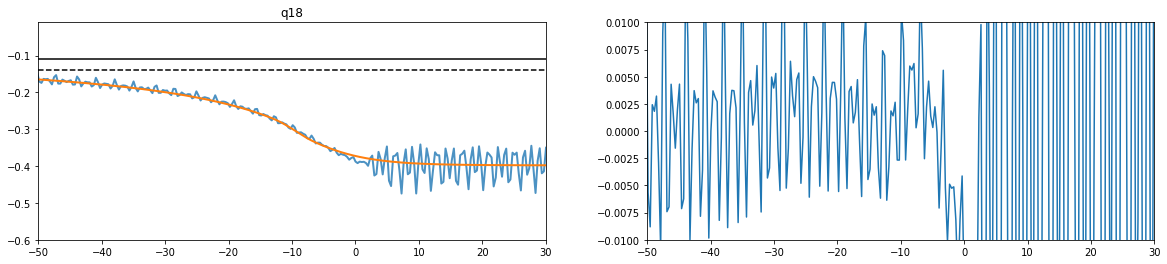

In [ ]:
for k in fit_psi4s_freq.keys():
    fig, axes = plt.subplots(1,2, figsize=(20,4))
    axes[0].plot(fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].y_data, lw=2, alpha=0.8)
    
#     plt.plot(fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].ramp_up)
#     plt.plot(fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].mr)
    
    axes[0].plot(fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].y_model, lw=2)
    
    axes[0].set_title(k)
#     plt.xlim(-60,30)
    axes[0].set_xlim(-50,30)
    axes[0].set_ylim(-0.6,-0.01)
#     plt.yscale('log')

    axes[0].axhline(-0.11, c='k')
    axes[0].axhline(-0.022 * 2 * np.pi, c='k', ls='--')

    axes[1].plot( fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].y_data - fit_psi4s_freq[k].y_model )
    axes[1].set_xlim(-50,30)
    axes[1].set_ylim(-0.01,0.01)
    
    
    plt.show()
    plt.close()

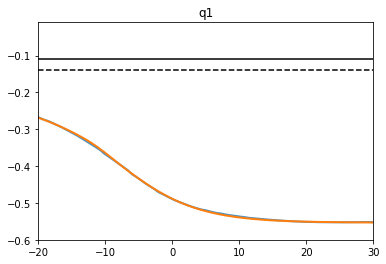

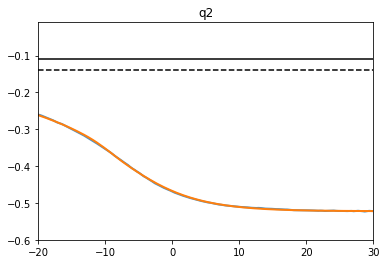

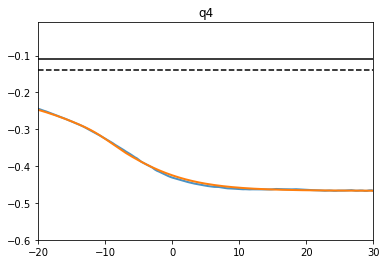

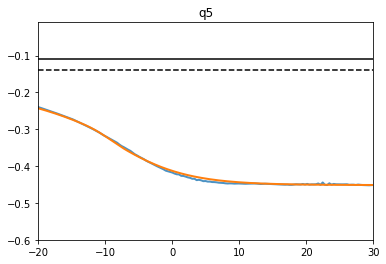

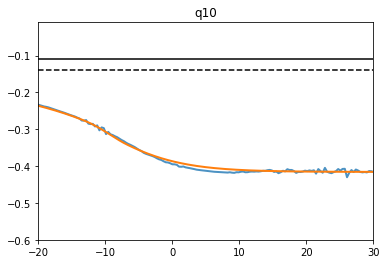

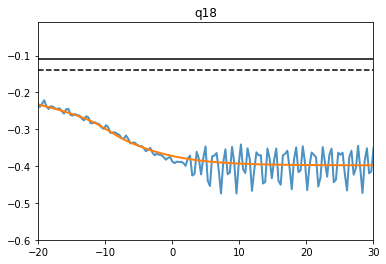

In [38]:
for k in fit_psi4s_freq.keys():
    plt.figure()
    plt.plot(fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].y_data, lw=2, alpha=0.8)
    
#     plt.plot(fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].ramp_up)
#     plt.plot(fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].mr)
    
    plt.plot(fit_psi4s_freq[k].t_data, fit_psi4s_freq[k].y_model, lw=2)
    
    plt.title(k)
#     plt.xlim(-60,30)
    plt.xlim(-20,30)
    plt.ylim(-0.6,-0.01)
#     plt.yscale('log')

    plt.axhline(-0.11, c='k')
    plt.axhline(-0.022 * 2 * np.pi, c='k', ls='--')

    plt.show()
    plt.close()

In [474]:
res=[]
for k in fit_psi4s_freq.keys():
    res.append([psi4s[k].q, fit_psi4s_freq[k].freq_mr_result.params['kappa'].value])
res=np.array(res)

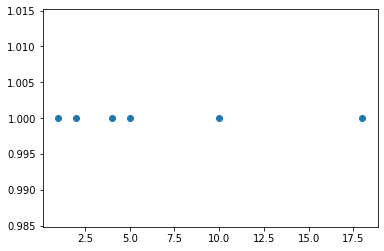

In [475]:
plt.figure()
plt.scatter(res[:,0], res[:,1])

# construct full model

In [476]:
# get amplitude
# get frequency
# get psi4

In [477]:
import scipy.integrate
def compute_integral(times, x):

    ix = IUS(times,  x)

    t1 = times[0]
    t2 = times[-1]
    res = []
    dt = times[1] - times[0]
    tss = np.linspace(t1+dt, t2, 1000)
    for ts in tss: 
        res.append(scipy.integrate.quad(ix, t1, ts)[0])
    res = np.array(res)

    ires = IUS(tss, res)
    return ires(times)



In [478]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

In [479]:
class FullModel(object):
    def __init__(self, psi4_object, t1, t2):
        """
        times to evaluate the model at
        """
        
        self.psi4_object = psi4_object
        
        self.mask = (self.psi4_object.times > t1) & (self.psi4_object.times < t2)
        
        self.times = self.psi4_object.times[self.mask]

        self.fit_fix_tdamp = Model(self.psi4_object)
        self.fit_fix_tdamp.fit_amp_ramp_up(fix_tdamp=True, t1=-800, t2=-10)
        self.fit_fix_tdamp.fit_amp_bob(fix_tdamp=True, t1=-10, t2=20)
        self.model_full_amp = self.fit_fix_tdamp.amp_model(self.times, t0=-10, sigma=10)
        
        self.freq_model = Model_frequency(self.psi4_object)
        self.freq_model.fit_freq_ramp_up(t1=-600, t2=-0.5)
        self.freq_model.fit_freq_mr(t1=-20, t2=40)
#         self.freq_model.fit_freq_mr(t1=-40, t2=40)
        self.model_full_freq = self.freq_model.freq_model(self.times, t0=-20, sigma=10)
        
        
        self.model_full_phase = compute_integral(self.times, self.model_full_freq)
        
        # average phase difference
        # this only works if times=None and therefore the same as the NR data times
        self.avg_phase_diff = np.mean(self.psi4_object.psi4lm_phase[self.mask] - self.model_full_phase)

        # this only works if times=None and therefore the same as the NR data times
        self.model_full_psi4lm = self.model_full_amp * np.exp(1.j * (self.model_full_phase + self.avg_phase_diff))

        # this only works if times=None and therefore the same as the NR data times
        self.match_array = match(self.model_full_psi4lm, self.psi4_object.psi4lm[self.mask], self.times)
        self.match = np.max(np.abs(self.match_array))
        
        
        

In [480]:
q1_full_model = FullModel(psi4s['q1'], t1=-400, t2=60)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 1819
    # variables        = 4
    chi-square         = 3.8727e-06
    reduced chi-square = 2.1337e-09
    Akaike info crit   = -36313.0793
    Bayesian info crit = -36291.0551
[[Variables]]
    tdamp:    11.70642 (fixed)
    tp:       31.7240596 +/- 0.08171694 (0.26%) (init = 20)
    lor_amp: -80.4346653 +/- 0.75178897 (0.93%) (init = 0)
    a0:      -0.37420868 +/- 8.5165e-04 (0.23%) (init = 0)
    a1:       945.802066 +/- 8.67369962 (0.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.994
    C(tp, lor_amp) = -0.994
    C(lor_amp, a0) =  0.774
    C(a0, a1)      = -0.769
    C(tp, a0)      = -0.720
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 91
    # variables        = 2
    chi-square         = 1.0060e-04
    reduced chi-square = 1.1304e-06
    A

In [481]:
q1_full_model.match

0.9997352007724715

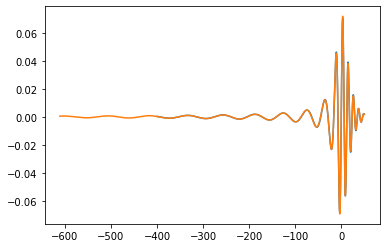

In [482]:
plt.figure()
plt.plot(q1_full_model.times, q1_full_model.model_full_psi4lm.real)
plt.plot(q1_full_model.psi4_object.times, q1_full_model.psi4_object.psi4lm.real)

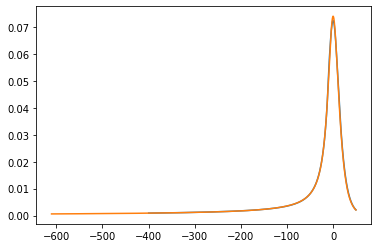

In [483]:
plt.figure()
plt.plot(q1_full_model.times, np.abs(q1_full_model.model_full_psi4lm))
plt.plot(q1_full_model.psi4_object.times, q1_full_model.psi4_object.psi4lm_amp)

(0.01, 0.1)

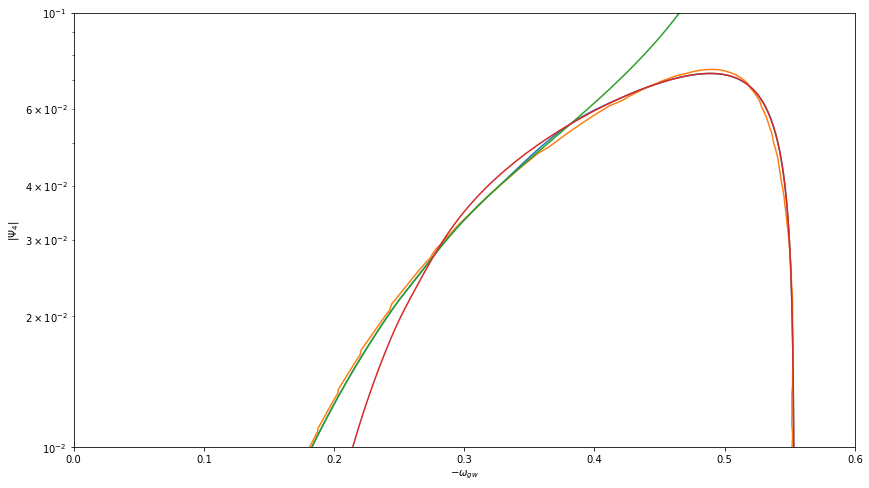

In [484]:
plt.figure(figsize=(14,8))
plt.plot(-q1_full_model.model_full_freq, np.abs(q1_full_model.model_full_psi4lm))
plt.plot(-q1_full_model.psi4_object.psi4lm_ang_freq, q1_full_model.psi4_object.psi4lm_amp)


plt.plot(-q1_full_model.model_full_freq, q1_full_model.fit_fix_tdamp.ramp_up, label='ramp-up model')
plt.plot(-q1_full_model.model_full_freq, q1_full_model.fit_fix_tdamp.bob, label='bob model')


plt.yscale('log')
plt.xlabel(r'$-\omega_{gw}$')
plt.ylabel(r'$|\Psi_4|$')
plt.xlim(0,0.6)
plt.ylim(1e-2,0.1)

In [485]:
full_model = {}
for k in psi4s.keys():
    full_model.update({k:FullModel(psi4s[k], t1=-600, t2=60)})

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 1819
    # variables        = 4
    chi-square         = 3.8727e-06
    reduced chi-square = 2.1337e-09
    Akaike info crit   = -36313.0793
    Bayesian info crit = -36291.0551
[[Variables]]
    tdamp:    11.70642 (fixed)
    tp:       31.7240596 +/- 0.08171694 (0.26%) (init = 20)
    lor_amp: -80.4346653 +/- 0.75178897 (0.93%) (init = 0)
    a0:      -0.37420868 +/- 8.5165e-04 (0.23%) (init = 0)
    a1:       945.802066 +/- 8.67369962 (0.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.994
    C(tp, lor_amp) = -0.994
    C(lor_amp, a0) =  0.774
    C(a0, a1)      = -0.769
    C(tp, a0)      = -0.720
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 91
    # variables        = 2
    chi-square         = 1.0060e-04
    reduced chi-square = 1.1304e-06
    A

In [489]:
for k in full_model.keys():
    print("{}: match = {}".format(k, full_model[k].match))

q1: match = 0.9997322100163054
q2: match = 0.9997705633756748
q4: match = 0.9995379898905815
q5: match = 0.9994842336214855
q10: match = 0.9990641709728316
q18: match = 0.9987358154776895


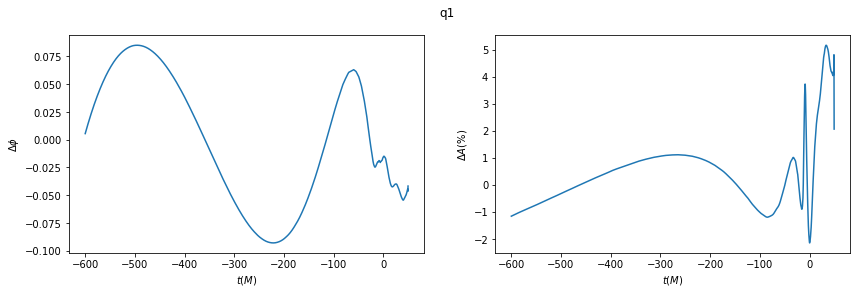

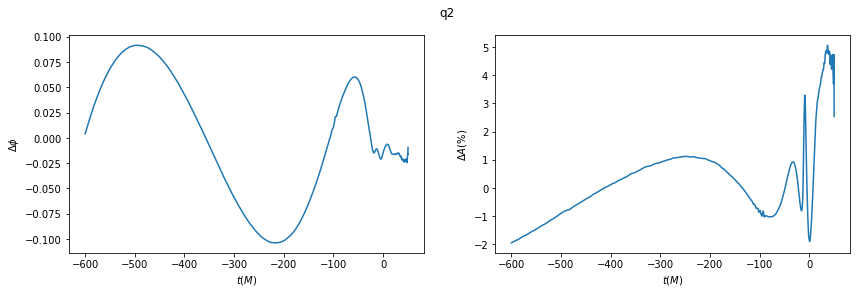

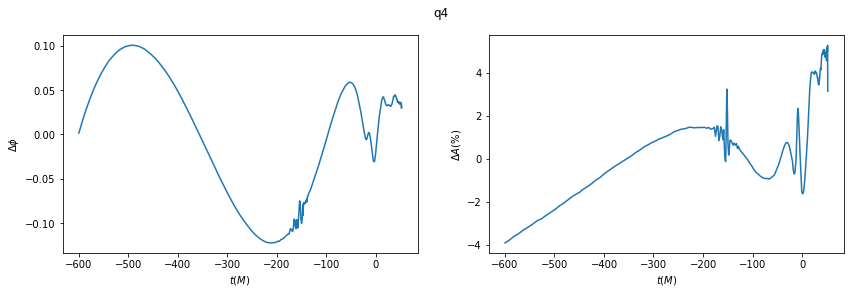

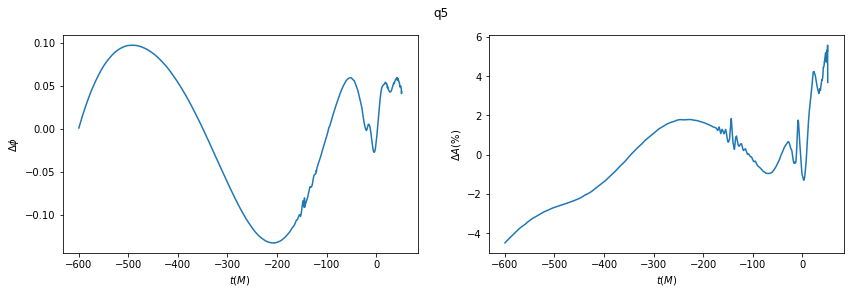

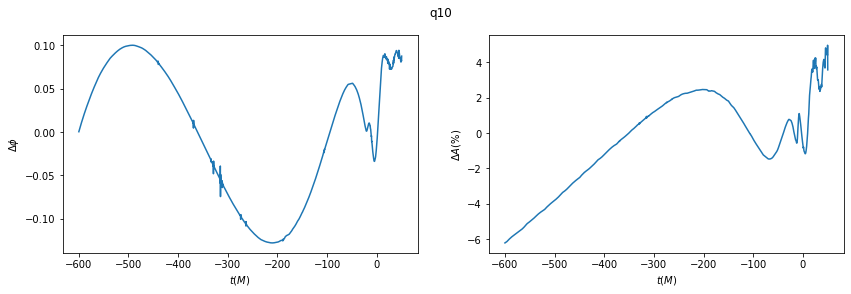

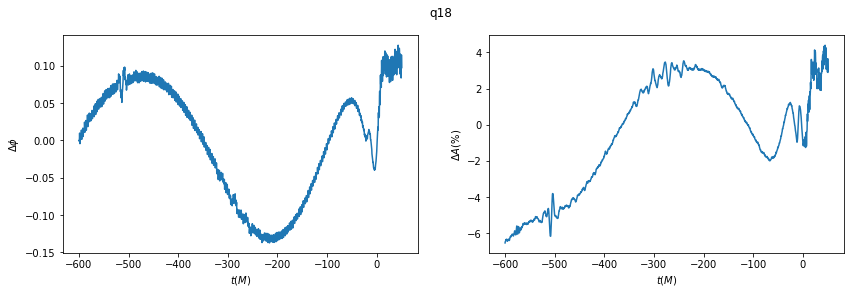

In [490]:
# compute amplitude and phase differences
for k in full_model.keys():
    times = full_model[k].times
    nr_amp = full_model[k].psi4_object.psi4lm_amp[full_model[k].mask]
    nr_phase = full_model[k].psi4_object.psi4lm_phase[full_model[k].mask]
    
    amp_diff = 100. * (full_model[k].model_full_amp - nr_amp) / nr_amp
    
    phase_diff = (full_model[k].model_full_phase + full_model[k].avg_phase_diff) - nr_phase
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    axes[0].plot(times, phase_diff)
    axes[1].plot(times, amp_diff)
    
    axes[0].set_ylabel(r"$\Delta \phi$")
    axes[1].set_ylabel(r"$\Delta A (\%)$")
    
    axes[0].set_xlabel(r"$t (M)$")
    axes[1].set_xlabel(r"$t (M)$")
    
    fig.suptitle(k)
    
    plt.show()
    plt.close()

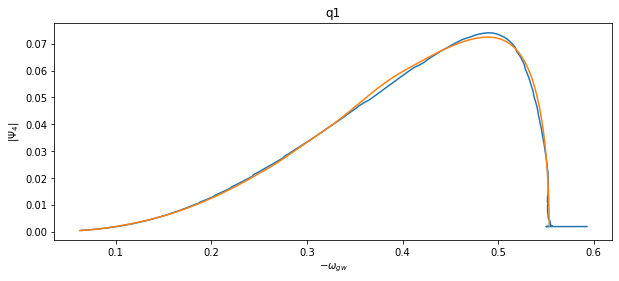

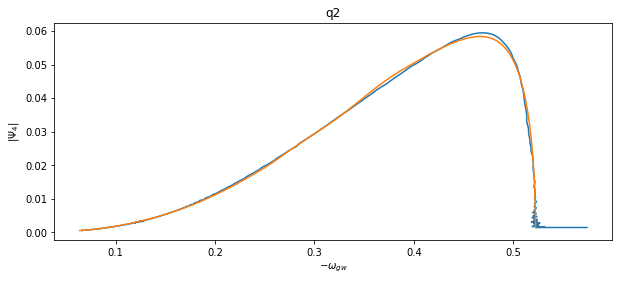

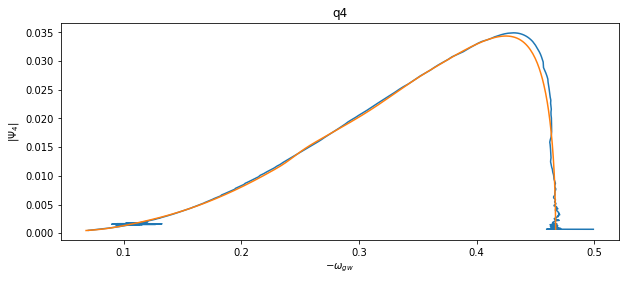

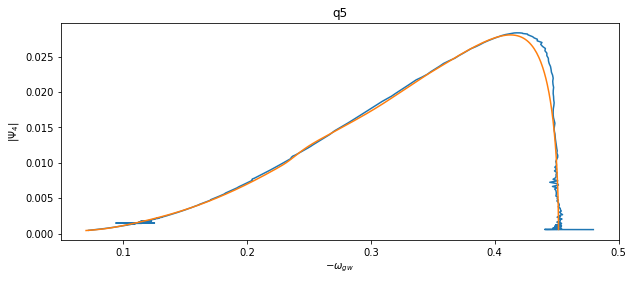

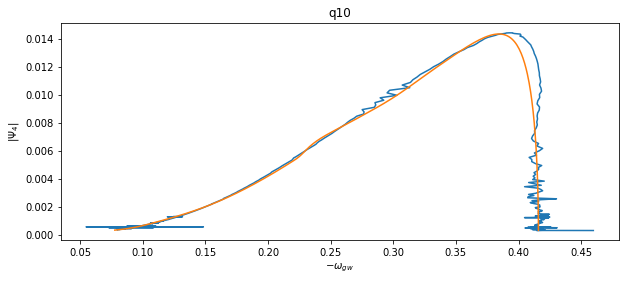

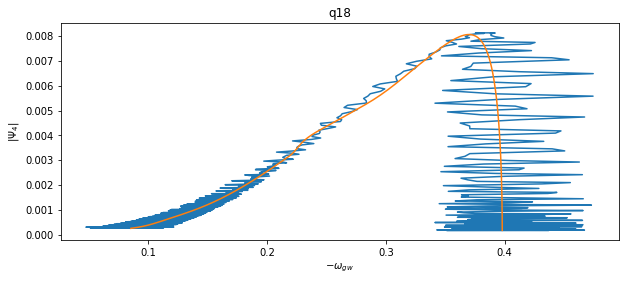

In [491]:
# plot amplitude as a function of frequnecy
for k in full_model.keys():
    times = full_model[k].times
    nr_amp = full_model[k].psi4_object.psi4lm_amp[full_model[k].mask]
    nr_freq = full_model[k].psi4_object.psi4lm_ang_freq[full_model[k].mask]
    
    
    plt.figure(figsize=(10,4))
    plt.plot(-nr_freq, nr_amp)
    plt.plot(-full_model[k].model_full_freq, np.abs(full_model[k].model_full_psi4lm))

    plt.xlabel(r'$-\omega_{gw}$')
    plt.ylabel(r'$|\Psi_4|$')
#     plt.xlim(0,0.6)
    plt.title(k)
    
    
    plt.show()
    plt.close()

In [492]:
q1_fit_fix_tdamp = Model(psi4s['q1'])
q1_fit_fix_tdamp.fit_amp_ramp_up(fix_tdamp=True, t1=-800, t2=-10)
q1_fit_fix_tdamp.fit_amp_bob(fix_tdamp=True, t1=-10, t2=20)
test_full_amp = q1_fit_fix_tdamp.amp_model(psi4s['q1'].times, t0=-10, sigma=10)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 1819
    # variables        = 4
    chi-square         = 3.8727e-06
    reduced chi-square = 2.1337e-09
    Akaike info crit   = -36313.0793
    Bayesian info crit = -36291.0551
[[Variables]]
    tdamp:    11.70642 (fixed)
    tp:       31.7240596 +/- 0.08171694 (0.26%) (init = 20)
    lor_amp: -80.4346653 +/- 0.75178897 (0.93%) (init = 0)
    a0:      -0.37420868 +/- 8.5165e-04 (0.23%) (init = 0)
    a1:       945.802066 +/- 8.67369962 (0.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.994
    C(tp, lor_amp) = -0.994
    C(lor_amp, a0) =  0.774
    C(a0, a1)      = -0.769
    C(tp, a0)      = -0.720
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 91
    # variables        = 2
    chi-square         = 1.0060e-04
    reduced chi-square = 1.1304e-06
    A

In [493]:
q1_freq_model = Model_frequency(psi4s['q1'])
print("fitting ramp up")
q1_freq_model.fit_freq_ramp_up(t1=-600, t2=-0.5)
print("\n")
print("fitting bob")
q1_freq_model.fit_freq_mr(t1=-20, t2=40)
test_full_freq = q1_freq_model.freq_model(psi4s['q1'].times, t0=-20, sigma=10)

fitting ramp up
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 102
    # data points      = 1816
    # variables        = 5
    chi-square         = 0.00283107
    reduced chi-square = 1.5633e-06
    Akaike info crit   = -24272.6289
    Bayesian info crit = -24245.1069
[[Variables]]
    t0:  8.17773813 +/- 0.03760131 (0.46%) (init = 0)
    a:   1133.29606 +/- 5.75870540 (0.51%) (init = 10)
    b:  -76.8252055 +/- 0.29081984 (0.38%) (init = 0)
    c:   5.89098177 +/- 0.01241271 (0.21%) (init = 0)
    d:  -180.276152 +/- 1.07102525 (0.59%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)  = -0.977
    C(c, d)  = -0.929
    C(t0, c) =  0.908
    C(t0, d) = -0.784
    C(a, c)  =  0.663
    C(a, d)  = -0.608
    C(b, c)  = -0.523
    C(t0, a) =  0.510
    C(b, d)  =  0.477
    C(t0, b) = -0.386


fitting bob
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 182
    # variables  

In [494]:
# self.psi4lm_amp
# self.psi4lm_ang_freq

(-100, 60)

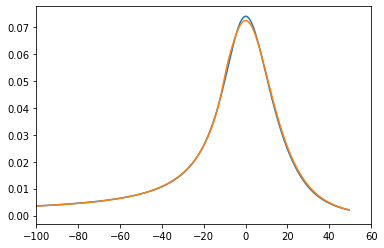

In [495]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_amp)
plt.plot(psi4s['q1'].times, test_full_amp)
plt.xlim(-100,60)

(-50, 60)

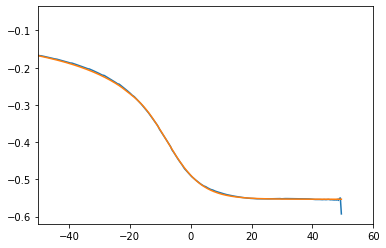

In [496]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_ang_freq)
plt.plot(psi4s['q1'].times, test_full_freq)
plt.xlim(-50,60)

(-600, 60)

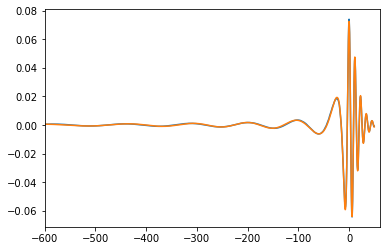

In [497]:
plt.figure()
plt.plot(psi4s['q1'].times, np.real(psi4s['q1'].psi4lm_amp * np.exp(-1.j * psi4s['q1'].psi4lm_ang_freq * psi4s['q1'].times)))
plt.plot(psi4s['q1'].times, np.real(test_full_amp * np.exp(-1.j * test_full_freq * psi4s['q1'].times)))
plt.xlim(-600,60)

In [498]:
model_phase = compute_integral(psi4s['q1'].times, test_full_freq)

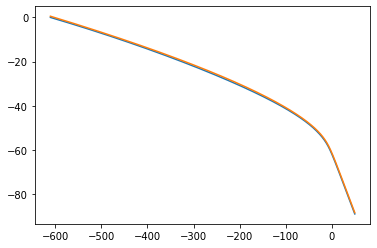

In [499]:
plt.figure()
plt.plot(psi4s['q1'].times, model_phase)
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_phase)

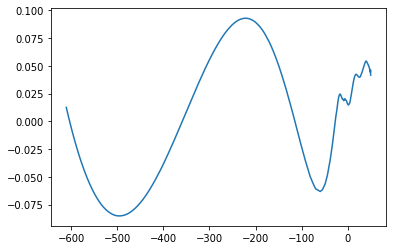

In [500]:
plt.figure()

avg_diff = np.mean(psi4s['q1'].psi4lm_phase - model_phase)

plt.plot(psi4s['q1'].times, (psi4s['q1'].psi4lm_phase - model_phase) - avg_diff)

In [501]:
avg_diff

0.5076987180208165

In [502]:
model_psi4 = test_full_amp * np.exp(1.j * (model_phase+avg_diff))

(-300, 60)

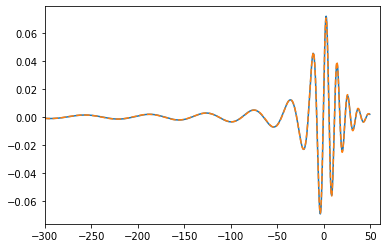

In [503]:
plt.figure()
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm.real)
plt.plot(psi4s['q1'].times, np.real(model_psi4), ls='--')
plt.xlim(-300,60)

In [504]:
t1=np.unwrap(np.angle(model_psi4))
t2=np.unwrap(np.angle(psi4s['q1'].psi4lm))

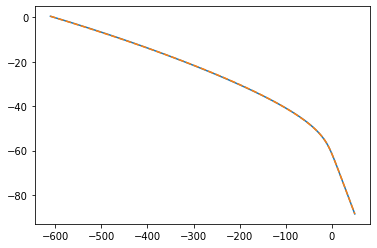

In [505]:
plt.figure()
plt.plot(psi4s['q1'].times, t1)
plt.plot(psi4s['q1'].times, t2, ls='--')

In [506]:
match_model_nr = match(model_psi4, psi4s['q1'].psi4lm, psi4s['q1'].times)

print("max match = {}".format( np.abs(match_model_nr).max() ))

max match = 0.9997322104550525


In [507]:
match_nr_nr = match(psi4s['q1'].psi4lm, psi4s['q1'].psi4lm, psi4s['q1'].times)

print("max match = {}".format( np.abs(match_nr_nr).max() ))

max match = 1.0000000000000004


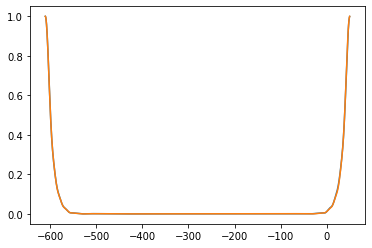

In [508]:
plt.plot(psi4s['q1'].times, np.abs(match_model_nr))
plt.plot(psi4s['q1'].times, np.abs(match_nr_nr))

# parameter space fits

In [509]:
q1 = full_model['q1']

In [510]:
type(q1.fit_fix_tdamp.amp_ramp_up_result)

lmfit.minimizer.MinimizerResult

In [511]:
q1.fit_fix_tdamp.amp_ramp_up_result.params

Parameters([('tdamp',
             <Parameter 'tdamp', value=11.706422641558191 (fixed), bounds=[-inf:inf]>),
            ('tp',
             <Parameter 'tp', value=31.724059606377864 +/- 0.0817, bounds=[-100:200]>),
            ('lor_amp',
             <Parameter 'lor_amp', value=-80.43466529850684 +/- 0.752, bounds=[-2000:2000]>),
            ('a0',
             <Parameter 'a0', value=-0.374208677950719 +/- 0.000852, bounds=[-2000:2000]>),
            ('a1',
             <Parameter 'a1', value=945.8020662962913 +/- 8.67, bounds=[-2000:4000]>)])

In [512]:
q1.fit_fix_tdamp.amp_ramp_up_result.params.keys()

odict_keys(['tdamp', 'tp', 'lor_amp', 'a0', 'a1'])

In [513]:
q1.fit_fix_tdamp.amp_ramp_up_result.params['tp']

<Parameter 'tp', value=31.724059606377864 +/- 0.0817, bounds=[-100:200]>

In [514]:
q1.fit_fix_tdamp.amp_ramp_up_result.params['tp'].vary

True

In [515]:
q1.fit_fix_tdamp.amp_bob_result.params

Parameters([('tdamp',
             <Parameter 'tdamp', value=11.706422641558191 (fixed), bounds=[-inf:inf]>),
            ('tp',
             <Parameter 'tp', value=0.023462518265318977 +/- 0.0479, bounds=[-100:200]>),
            ('ap',
             <Parameter 'ap', value=0.07242248188231315 +/- 0.000144, bounds=[-2000:2000]>)])

In [516]:
q1.freq_model.freq_ramp_up_result.params

Parameters([('t0',
             <Parameter 't0', value=8.177738126671002 +/- 0.0376, bounds=[-30:300]>),
            ('a',
             <Parameter 'a', value=1133.2960622251944 +/- 5.76, bounds=[-2000:5000]>),
            ('b',
             <Parameter 'b', value=-76.8252055250448 +/- 0.291, bounds=[-2000:20000]>),
            ('c',
             <Parameter 'c', value=5.890981773556632 +/- 0.0124, bounds=[-2000:2000]>),
            ('d',
             <Parameter 'd', value=-180.27615212684032 +/- 1.07, bounds=[-1000000:4000]>)])

In [517]:
q1.freq_model.freq_mr_result.params

Parameters([('t0',
             <Parameter 't0', value=-8.027348963173381 +/- 0.0276, bounds=[-200:200]>),
            ('kappa', <Parameter 'kappa', value=1 (fixed), bounds=[-inf:inf]>),
            ('b',
             <Parameter 'b', value=11.706422641558191 (fixed), bounds=[-inf:inf]>),
            ('om_f',
             <Parameter 'om_f', value=-0.5534661793193033 (fixed), bounds=[-inf:inf]>),
            ('offset',
             <Parameter 'offset', value=-0.23408895335253987 +/- 0.000534, bounds=[-200:200]>)])

In [518]:
class ParSpaceFits(object):
    def __init__(self, name, full_model_dict):
        self.name = name
        self.full_model_dict = full_model_dict
        
        self.results = {}
        
        for k in self.full_model_dict.keys():
            
            q = self.full_model_dict[k].psi4_object.nrdata.q
            eta = self.full_model_dict[k].psi4_object.nrdata.eta
            self.results.update({k:{"fixed":{}, "vary":{}, 'q':q, 'eta':eta}})
            if self.name == "amp_ramp_up_result":
                for pk in self.full_model_dict[k].fit_fix_tdamp.amp_ramp_up_result.params.keys():
                    entry = self.full_model_dict[k].fit_fix_tdamp.amp_ramp_up_result.params[pk]
                    v = entry.value
                    vary = entry.vary
                    if vary is True:
                        self.results[k]["vary"].update({pk:v})
                    else:
                        self.results[k]["fixed"].update({pk:v})
            elif self.name == "amp_bob_result":
                for pk in self.full_model_dict[k].fit_fix_tdamp.amp_bob_result.params.keys():
                    entry = self.full_model_dict[k].fit_fix_tdamp.amp_bob_result.params[pk]
                    v = entry.value
                    vary = entry.vary
                    if vary is True:
                        self.results[k]["vary"].update({pk:v})
                    else:
                        self.results[k]["fixed"].update({pk:v})
            elif self.name == "freq_ramp_up_result":
                for pk in self.full_model_dict[k].freq_model.freq_ramp_up_result.params.keys():
                    entry = self.full_model_dict[k].freq_model.freq_ramp_up_result.params[pk]
                    v = entry.value
                    vary = entry.vary
                    if vary is True:
                        self.results[k]["vary"].update({pk:v})
                    else:
                        self.results[k]["fixed"].update({pk:v})
            elif self.name == "freq_mr_result":
                for pk in self.full_model_dict[k].freq_model.freq_mr_result.params.keys():
                    entry = self.full_model_dict[k].freq_model.freq_mr_result.params[pk]
                    v = entry.value
                    vary = entry.vary
                    if vary is True:
                        self.results[k]["vary"].update({pk:v})
                    else:
                        self.results[k]["fixed"].update({pk:v})

                        
        k = list(self.full_model_dict.keys())[0]
        self.vary_parnames = self.results[k]["vary"].keys()
        self.fixed_parnames = self.results[k]["fixed"].keys()
                        
                        
        self.build_arrays()
        
        self.par_space_result = {}
        for k in self.vary_parnames:
            self.par_space_result.update({k:self.fit_par_space(yname=k, xname='eta')})
        
        
    def build_arrays(self):
        
        self.ready_to_fit = {'x':{}, 'y':{}}
        
        parnames = self.results[list(self.results.keys())[0]]['vary']
        
        for parname in parnames:
            array_eta = []
            array_q = []
            array_y = []
            for k in self.results.keys():
                array_eta.append(self.results[k]['eta'])
                array_q.append(self.results[k]['q'])
                array_y.append(self.results[k]['vary'][parname])
            

            self.ready_to_fit['x'].update({"eta":np.array(array_eta), "q":np.array(array_q)})
            self.ready_to_fit['y'].update({parname:np.array(array_y)})
            
            
            
    def model_evaluate(self, parname, x):
        params = self.par_space_result[parname].params
        return self.model_par_space(params, x)
            
    def model_par_space(self, params, x):

        a = params['a']
        b = params['b']
        c = params['c']
        d = params['d']

#         model = a + b*x + c*np.sqrt(x)
#         model = a + b*x + c*np.log(x)
#         model = a + b*x + c*x**2
#         model = a + b*x + c*x**2 + d*x**3
#         model = a + b*x + d*x**3
        model = a + b*x + d*x**2

        return model

    def model_par_space_to_min(self, params, x, y):
        model = self.model_par_space(params, x)
        return model - y

    def fit_par_space(self, yname, xname='eta'):
        
        
        fit_x = self.ready_to_fit['x'][xname]
        fit_y = self.ready_to_fit['y'][yname]
    
    
        # sort them by first column i.e. mass-raito or eta
        fit_xy = np.array([fit_x, fit_y]).T
        tmp = sorted(fit_xy, key=lambda x: x[0])
        tmp = np.array(tmp).T
        self.fit_x, self.fit_y = tmp[0], tmp[1]

        # create a set of Parameters
        params = Parameters()

        params.add('a', value=10., min=-20000, max=50000)
        params.add('b', value=300., min=-20000, max=20000)
        params.add('c', value=400., min=-40000, max=10000)
        params.add('d', value=300., min=-20000, max=20000)

        fcn2min = self.model_par_space_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_x, self.fit_y))

        result = minner.minimize()

        # calculate final result
        final = self.fit_y + result.residual

        # write error report
        # report_fit(result)
        return result


In [519]:
PSF_amp_ramp=ParSpaceFits("amp_ramp_up_result", full_model)
PSF_amp_bob=ParSpaceFits("amp_bob_result", full_model)
PSF_freq_ramp=ParSpaceFits("freq_ramp_up_result", full_model)
PSF_freq_mr=ParSpaceFits("freq_mr_result", full_model)

In [520]:
print(PSF_amp_ramp.results['q1']['vary'].keys())
print(PSF_amp_bob.results['q1']['vary'].keys())
print(PSF_freq_ramp.results['q1']['vary'].keys())
print(PSF_freq_mr.results['q1']['vary'].keys())

dict_keys(['tp', 'lor_amp', 'a0', 'a1'])
dict_keys(['tp', 'ap'])
dict_keys(['t0', 'a', 'b', 'c', 'd'])
dict_keys(['t0', 'offset'])


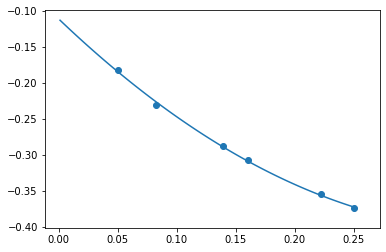

In [521]:
xs = np.linspace(0.001,0.25,100)


plt.figure()
plt.scatter(PSF_amp_ramp.ready_to_fit['x']['eta'], PSF_amp_ramp.ready_to_fit['y']['a0'])
plt.plot(xs, PSF_amp_ramp.model_evaluate('a0', xs))

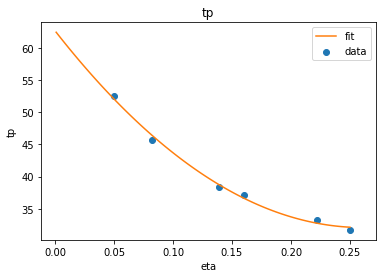

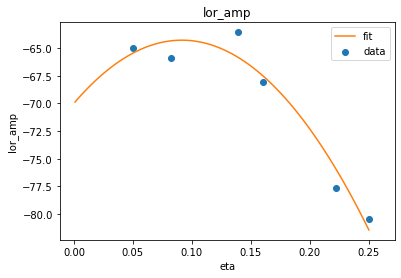

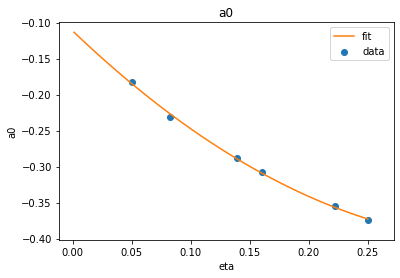

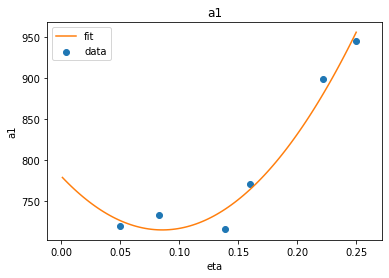

In [522]:
part = PSF_amp_ramp

xs = np.linspace(0.001,0.25,100)

for y in part.vary_parnames:
    plt.figure()
    plt.scatter(part.ready_to_fit['x']['eta'], part.ready_to_fit['y'][y], label='data')
    plt.plot(xs, part.model_evaluate(y, xs), c='C1', label='fit')
    plt.xlabel('eta')
    plt.legend()
    plt.ylabel(y)
    plt.title(y)
    plt.show()
    plt.close()

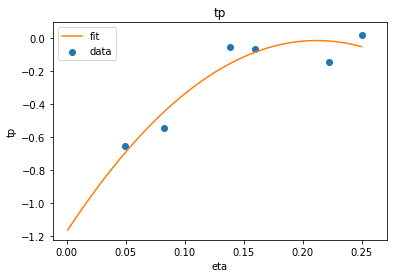

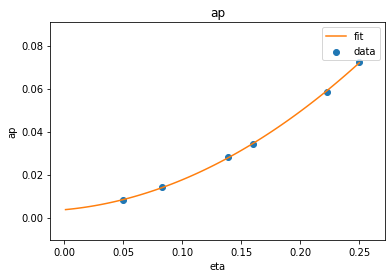

In [523]:
part = PSF_amp_bob

xs = np.linspace(0.001,0.25,100)

for y in part.vary_parnames:
    plt.figure()
    plt.scatter(part.ready_to_fit['x']['eta'], part.ready_to_fit['y'][y], label='data')
    plt.plot(xs, part.model_evaluate(y, xs), c='C1', label='fit')
    plt.xlabel('eta')
    plt.legend()
    plt.ylabel(y)
    plt.title(y)
    plt.show()
    plt.close()

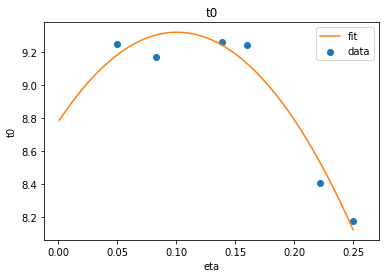

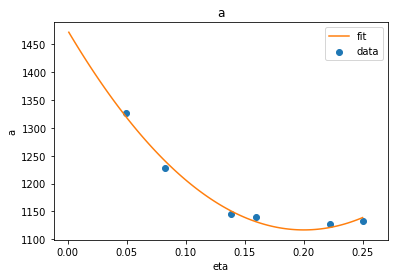

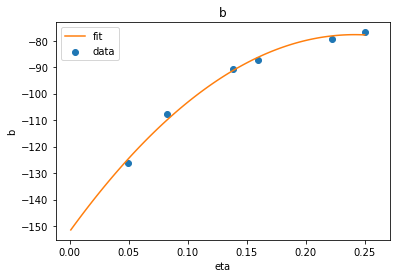

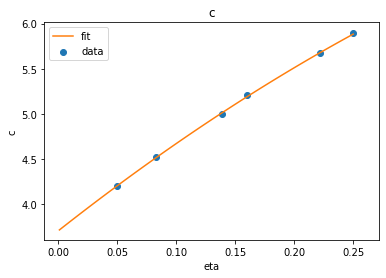

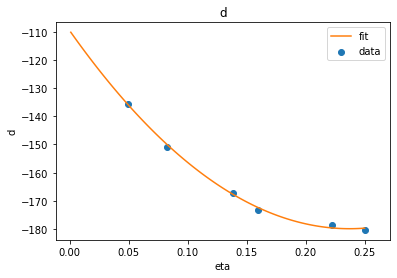

In [524]:
part = PSF_freq_ramp

xs = np.linspace(0.001,0.25,100)

for y in part.vary_parnames:
    plt.figure()
    plt.scatter(part.ready_to_fit['x']['eta'], part.ready_to_fit['y'][y], label='data')
    plt.plot(xs, part.model_evaluate(y, xs), c='C1', label='fit')
    plt.xlabel('eta')
    plt.legend()
    plt.ylabel(y)
    plt.title(y)
    plt.show()
    plt.close()

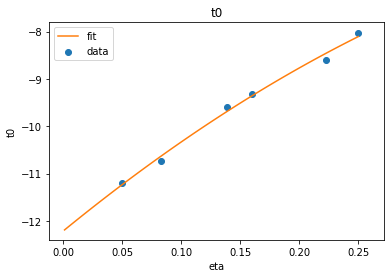

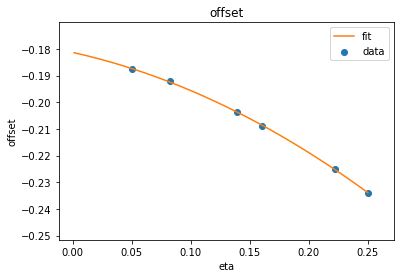

In [525]:
part = PSF_freq_mr

xs = np.linspace(0.001,0.25,100)

for y in part.vary_parnames:
    plt.figure()
    plt.scatter(part.ready_to_fit['x']['eta'], part.ready_to_fit['y'][y], label='data')
    plt.plot(xs, part.model_evaluate(y, xs), c='C1', label='fit')
    plt.xlabel('eta')
    plt.legend()
    plt.ylabel(y)
    plt.title(y)
    plt.show()
    plt.close()

# Mark 1 model class

In [526]:
PSF_amp_ramp.results['q1']['fixed']

{'tdamp': 11.706422641558191}

In [527]:
PSF_amp_ramp.fixed_parnames

dict_keys(['tdamp'])

In [528]:
PSF_amp_bob.fixed_parnames

dict_keys(['tdamp'])

In [529]:
PSF_freq_mr.fixed_parnames

dict_keys(['kappa', 'b', 'om_f'])

In [530]:
PSF_freq_ramp.fixed_parnames

dict_keys([])

In [531]:
a=PSF_freq_ramp.full_model_dict['q1'].freq_model.freq_model

In [532]:
a?

Signature: a(times, t0=-20, sigma=10, params_ramp_up=None, params_mr=None)
Docstring: <no docstring>
File:      ~/work/git/stk/ml/waveforms/bob/old-laptop/<ipython-input-468-32294becb989>
Type:      method


In [533]:
PSF_freq_ramp.full_model_dict['q1'].freq_model

In [534]:
PSF_freq_ramp.full_model_dict['q1'].freq_model.freq_model

<bound method Model_frequency.freq_model of <__main__.Model_frequency object at 0x1a2eafc9d0>>

In [535]:
PSF_freq_mr.fixed_parnames

dict_keys(['kappa', 'b', 'om_f'])

In [536]:
class ModelMark1(object):
    def __init__(self, times, q):
        """
        times to evaluate the model at
        q : mass-ratio
        """
        
        self.times = times
        self.q = q
        self.eta = eta_from_q(self.q)
        
        self.fin_spin = phenom.remnant.FinalSpin0815(self.eta, 0, 0)
        self.fring = phenom.remnant.fring(self.eta, 0, 0, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(self.eta, 0, 0, self.fin_spin)
        
        
        # amplitude model
        # build dict for params. parameter space fit values and fixed values
        # ramp_up
        params_ramp_up={}
        for k in PSF_amp_ramp.vary_parnames:
            params_ramp_up.update({k : PSF_amp_ramp.model_evaluate(k, self.eta)})
        params_ramp_up.update({'tdamp' : 1./self.fdamp/2./np.pi})
        
        # bob
        params_bob={}
        for k in PSF_amp_bob.vary_parnames:
            params_bob.update({k : PSF_amp_bob.model_evaluate(k, self.eta)})
        params_bob.update({'tdamp' : 1./self.fdamp/2./np.pi})
        
        amp_model_func = PSF_amp_ramp.full_model_dict['q1'].fit_fix_tdamp.amp_model
        self.amp_model = amp_model_func(self.times, t0=-10, sigma=10, params_ramp_up=params_ramp_up, params_bob=params_bob)

        
        # frequency model
        # build dict for params. parameter space fit values and fixed values
        # ramp_up
        params_freq_ramp_up={}
        for k in PSF_freq_ramp.vary_parnames:
            params_freq_ramp_up.update({k : PSF_freq_ramp.model_evaluate(k, self.eta)})
        
        # mr
        params_mr={}
        for k in PSF_freq_mr.vary_parnames:
            params_mr.update({k : PSF_freq_mr.model_evaluate(k, self.eta)})
        params_mr.update({
            'om_f' : -self.fring*2.*np.pi,
            'kappa' : 1.,
            'b' : 1./self.fdamp/2./np.pi
        })
        
        freq_model_func = PSF_freq_ramp.full_model_dict['q1'].freq_model.freq_model
        self.freq_model = freq_model_func(self.times, t0=-20, sigma=10, params_ramp_up=params_freq_ramp_up, params_mr=params_mr)
        
        # compute phase
        self.model_phase = compute_integral(self.times, self.freq_model)
        
        # psi4
        self.psi4lm = self.amp_model * np.exp(1.j * (self.model_phase))

In [537]:
psi4s['q1'].times[0]

-610.4752376188094

In [538]:
psi4s['q1'].times[-1]

49.52476238119061

In [539]:
# Mark1 = ModelMark1(np.linspace(-600, 60, 2000), 1)
Mark1 = ModelMark1(psi4s['q1'].times, 1)

(-100, 50)

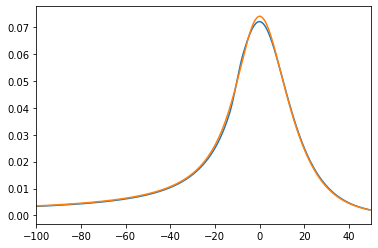

In [540]:
plt.figure()
plt.plot(Mark1.times, Mark1.amp_model)
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_amp)
plt.xlim(-100,50)

(-100, 50)

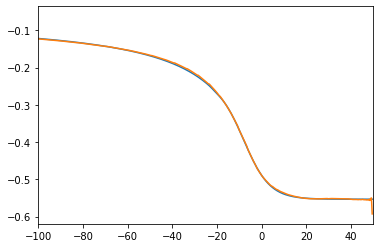

In [541]:
plt.figure()
plt.plot(Mark1.times, Mark1.freq_model)
plt.plot(psi4s['q1'].times, psi4s['q1'].psi4lm_ang_freq)
plt.xlim(-100,50)

In [542]:
Mark1dict = {}
matches = {}
for k in psi4s.keys():
    q = psi4s[k].q
    Mark1dict.update({k: ModelMark1(psi4s[k].times, q)})
    m = match(Mark1dict[k].psi4lm, psi4s[k].psi4lm, Mark1dict[k].times)
    matches.update({k:m})
    print("{} = {}".format(q, np.max(np.abs(matches[k]))))

1.0 = 0.9995274129387737
2.0 = 0.9995355166602026
4.0 = 0.9993685879047939
5.0 = 0.9994852517434063
10.0 = 0.9979361417074312
18.0 = 0.9983124011791817


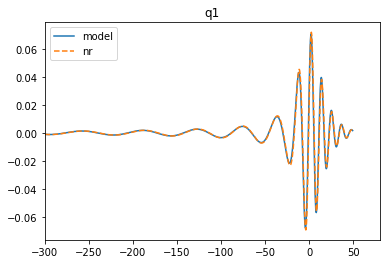

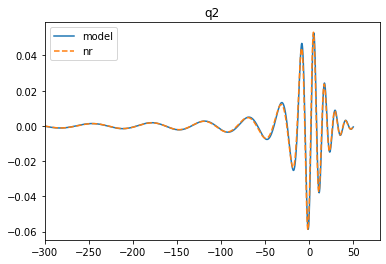

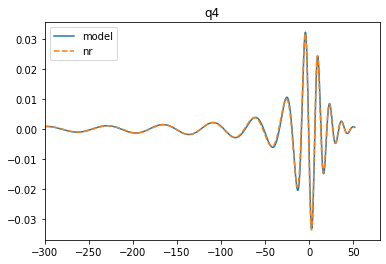

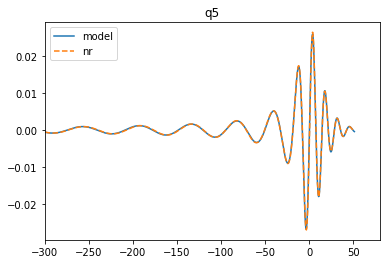

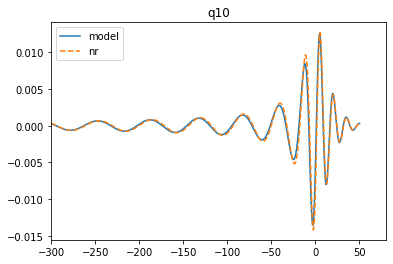

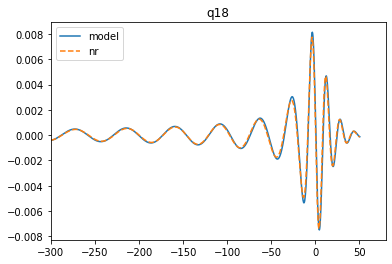

In [543]:
align_phases = True

for k in psi4s.keys():
    
    if align_phases:
        m_phase = np.unwrap(np.angle(Mark1dict[k].psi4lm))
        nr_phase = np.unwrap(np.angle(psi4s[k].psi4lm))
        avg_diff = np.mean(m_phase - nr_phase)
    
    
    plt.figure()
    plt.plot(Mark1dict[k].times, np.real(Mark1dict[k].psi4lm * np.exp(-1.j*avg_diff)), label='model')
    plt.plot(psi4s[k].times, np.real(psi4s[k].psi4lm), label='nr', ls='--')
#     plt.xlim(-400,80)
    plt.xlim(-300,80)
#     plt.xlim(-500,80)
#     plt.yscale('log')
    plt.legend()
    plt.title(k)
    plt.show()
    plt.close()

## extrapolating 

In [544]:
Mark1_ex = ModelMark1(np.linspace(-2000, 60, 2000), 30)

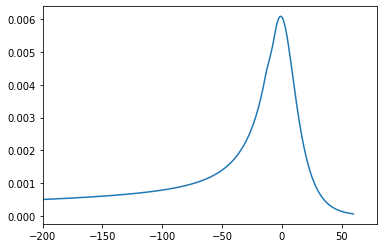

In [545]:
plt.figure()
# plt.plot(Mark1_ex.times, np.real(Mark1_ex.psi4lm), label='real')
# plt.plot(Mark1_ex.times, np.imag(Mark1_ex.psi4lm), label='imag')
plt.plot(Mark1_ex.times, np.abs(Mark1_ex.psi4lm), label='abs')
# plt.xlim(-500,80)
plt.xlim(-200,80)
# plt.xlim(-1000,80)
# plt.legend()
# plt.yscale('log')
plt.show()
plt.close()

# compare strains - don't look so good

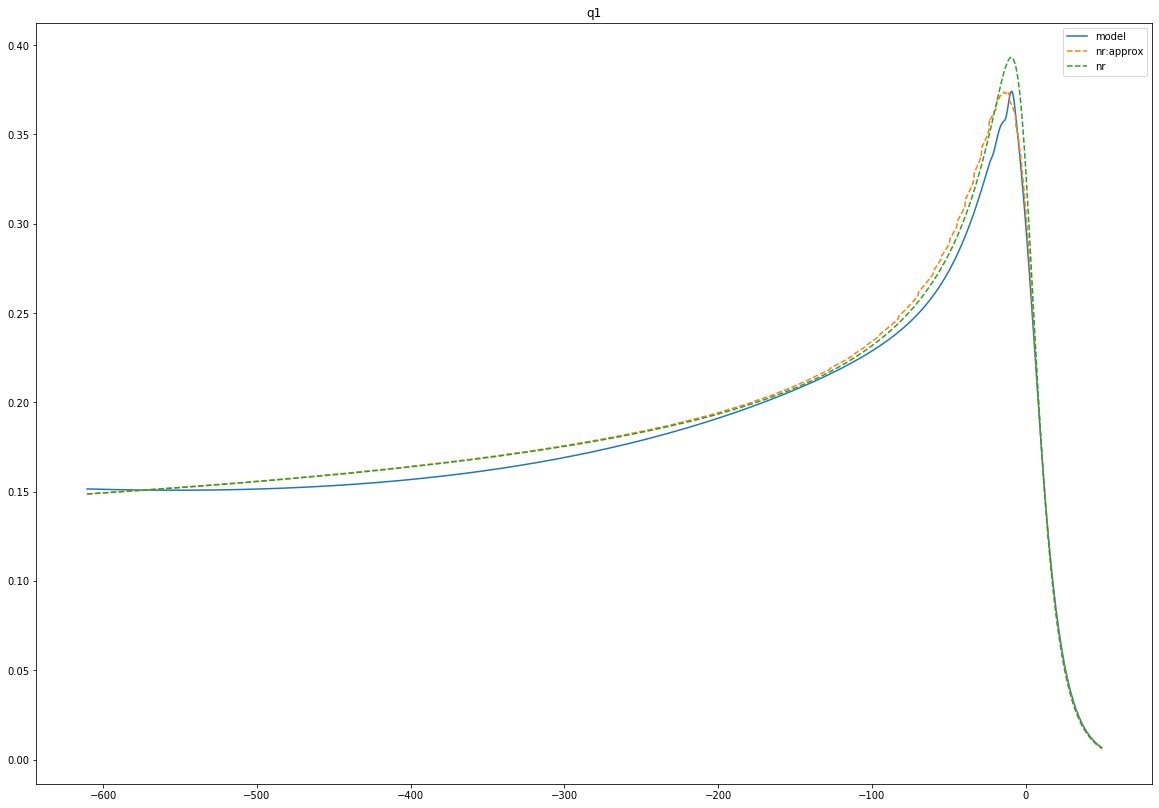

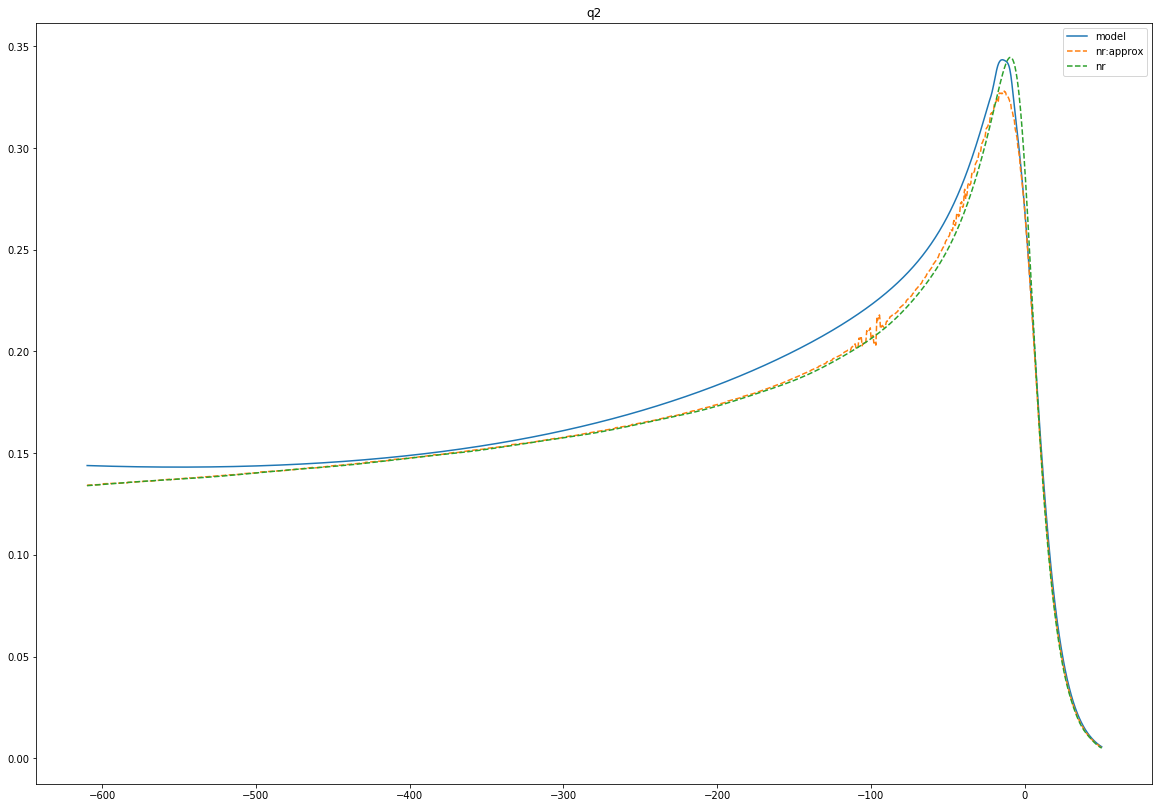

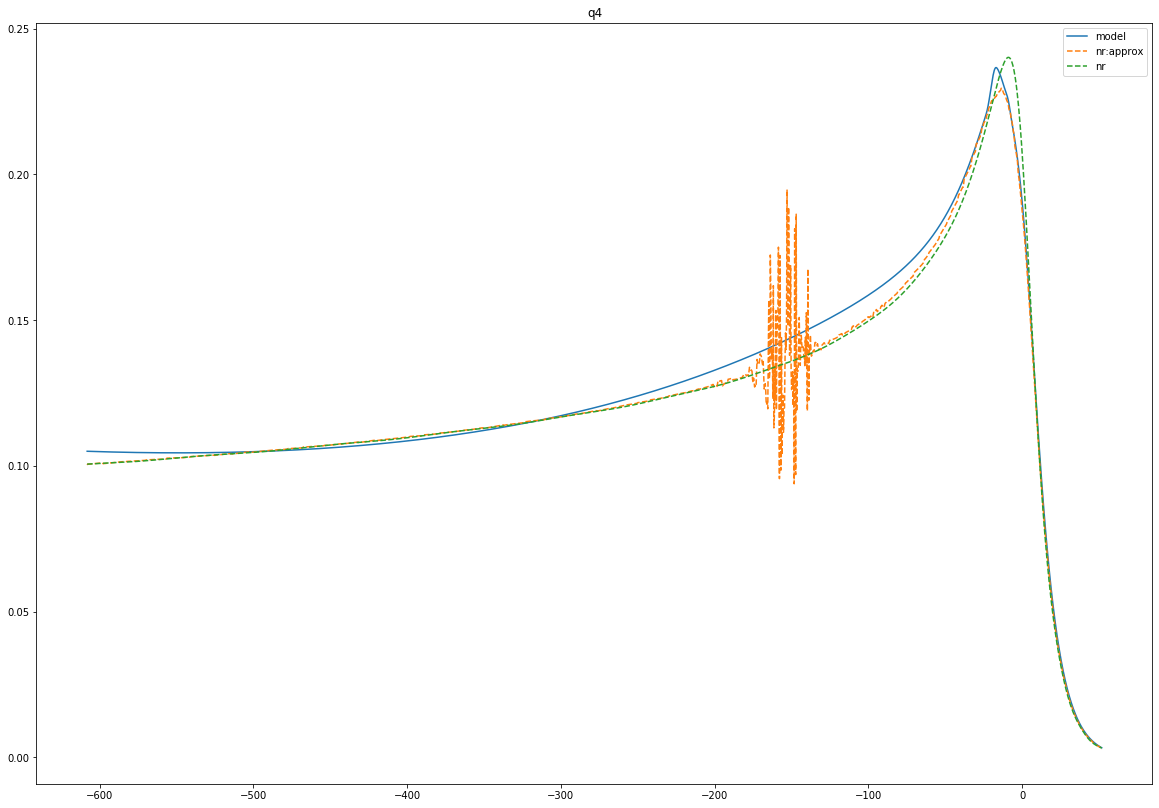

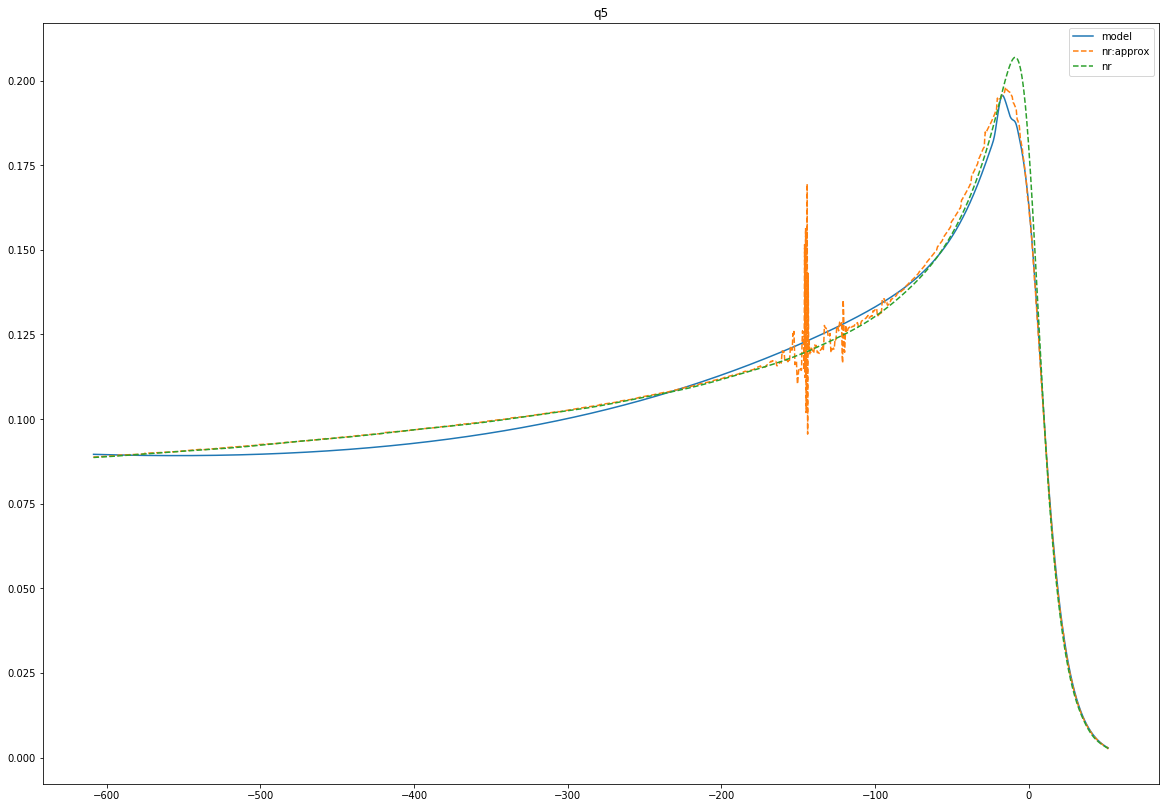

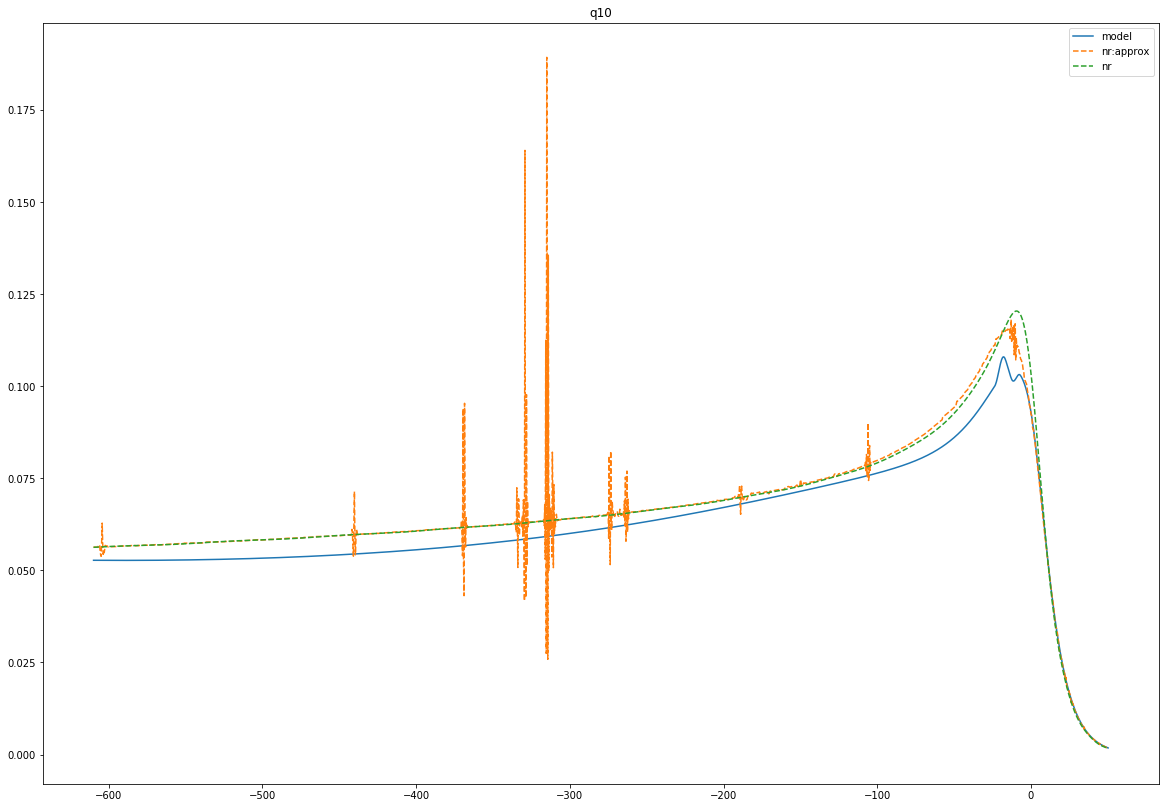

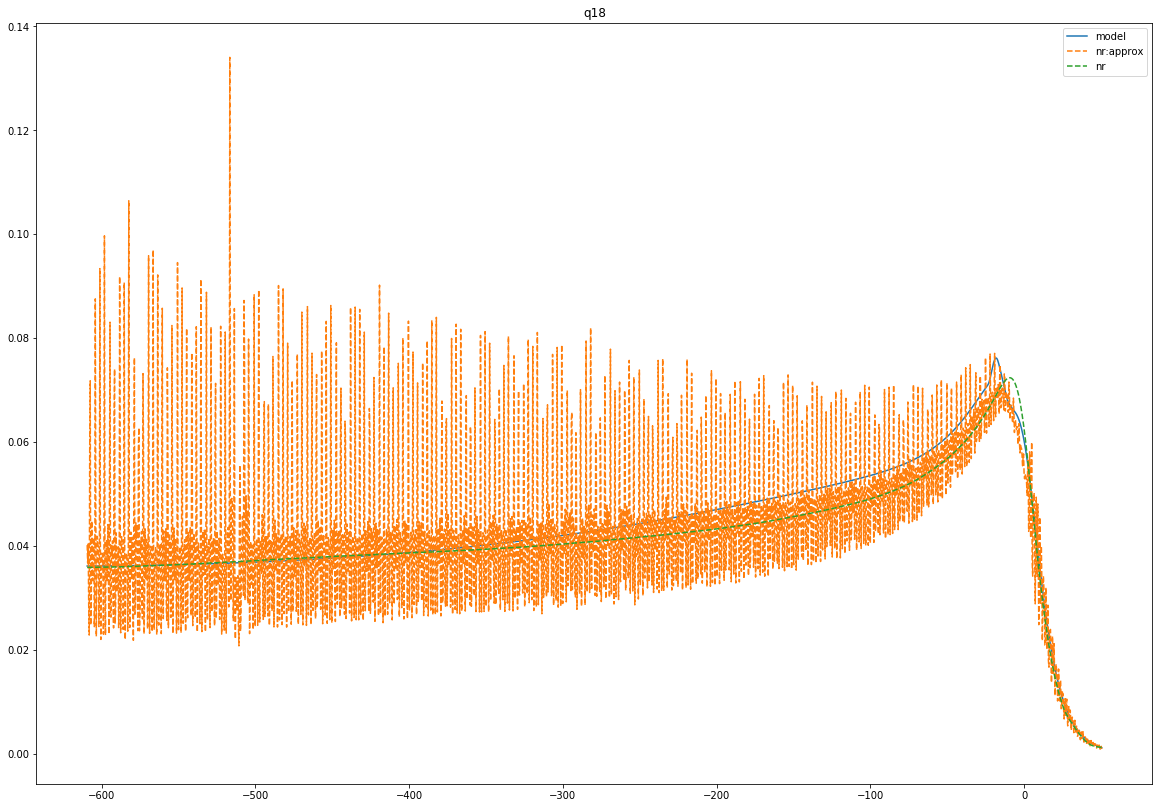

In [562]:

for k in psi4s.keys():
    plt.figure(figsize=(20,14))
    plt.plot(Mark1dict[k].times, Mark1dict[k].amp_model / Mark1dict[k].freq_model**2, label='model')
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_amp / psi4s[k].psi4lm_ang_freq**2, label='nr:approx', ls='--')
    plt.plot(psi4s[k].times, psi4s[k].hlm_amp, label='nr', ls='--')
#     plt.xlim(-400,80)
#     plt.xlim(-300,80)
#     plt.xlim(-500,80)
#     plt.yscale('log')
    plt.legend()
    plt.title(k)
    plt.show()
    plt.close()